## QA script for population projections

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


#### Load data

In [2]:
# os.chdir(r'Q:\Teams\D&PA\Demography\dev\population_projections\outputs\flexible_area_model\2022_based\Explorer_tool_data')
# combined_10yr_fert = pd.read_csv('combined_10yr_central_fert.csv').iloc[:, 1:]

In [3]:
os.chdir(r'C:\Users\user\Documents\population_data\combined_10yr_central_fert')
combined_10yr_fert = pd.read_csv('combined_10yr_central_fert.csv').iloc[:, 1:]

C:\Users\user\AppData\Local\Temp\ipykernel_20132\1627369184.py:2: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_10yr_fert = pd.read_csv('combined_10yr_central_fert.csv').iloc[:, 1:]


In [4]:
combined_10yr_fert

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name
0,E09000001,City of London,2012.0,female,0.0,32.0,births,NaN,NaN
1,E09000001,City of London,2012.0,male,0.0,24.0,births,NaN,NaN
2,E09000001,City of London,2013.0,female,0.0,36.0,births,NaN,NaN
3,E09000001,City of London,2013.0,male,0.0,35.0,births,NaN,NaN
4,E09000001,City of London,2014.0,female,0.0,26.0,births,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15428057,E09000033,Westminster,2050.0,male,86.0,16.9,popn,E05013809,Westbourne
15428058,E09000033,Westminster,2050.0,male,87.0,13.3,popn,E05013809,Westbourne
15428059,E09000033,Westminster,2050.0,male,88.0,11.0,popn,E05013809,Westbourne
15428060,E09000033,Westminster,2050.0,male,89.0,9.9,popn,E05013809,Westbourne


In [5]:
combined_10yr_fert_boroughs = combined_10yr_fert[combined_10yr_fert['gss_code_ward'].isna()]

In [6]:
combined_10yr_fert_ward = combined_10yr_fert[~combined_10yr_fert['gss_code_ward'].isna()]

In [7]:
#min and max year
def get_year_range(df):
    return df['year'].max(), df['year'].min()

In [8]:
#year ranges
print(get_year_range(combined_10yr_fert))
print(get_year_range(combined_10yr_fert_ward))
print(get_year_range(combined_10yr_fert_boroughs))


(2050.0, 2002.0)
(2050.0, 2011.0)
(2050.0, 2002.0)


### Basic checks

##### missing values

In [9]:
missing_values = combined_10yr_fert.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 gss_code              0
la_name               0
year                  0
sex                   0
age                   0
value                 0
component             0
gss_code_ward    771342
ward_name        771342
dtype: int64


##### Duplicates 

In [10]:
duplicates = combined_10yr_fert.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


#### Basic description

In [11]:
describe_wards = combined_10yr_fert.describe()

##### Description by components

In [12]:
# Group by 'component' column
grouped = combined_10yr_fert.groupby('component')

# Apply describe to each group
described_groups = grouped.describe()

In [13]:
described_groups

year                                                   \
               count         mean        std     min      25%     50%   
component                                                               
births       55614.0  2031.000000  11.254730  2012.0  2021.00  2031.0   
deaths     5060874.0  2031.000000  11.254630  2012.0  2021.00  2031.0   
netflow    5120934.0  2030.712656  11.499358  2002.0  2021.00  2031.0   
popn       5190640.0  2030.500000  11.543397  2011.0  2020.75  2030.5   

                                  age        ...                  value  \
               75%     max      count  mean  ...   75%   max      count   
component                                    ...                          
births     2041.00  2050.0    55614.0   0.0  ...   0.0   0.0    55614.0   
deaths     2041.00  2050.0  5060874.0  45.0  ...  68.0  90.0  5060874.0   
netflow    2041.00  2050.0  5120934.0  45.0  ...  68.0  90.0  5120934.0   
popn       2040.25  2050.0  5190640.0  45.0  ...  68.0  90.0  5190640.0   

                                                                     
                 mean         std    min   25%   50%    75%     max  
component                                                            
births     162.293288  377.997791    0.0  59.9  81.6  110.9  3264.0  
deaths       0.885798    6.327541    0.0   0.0   0.1    0.6   825.2  
netflow     -0.182117   20.742161 -713.0  -2.3  -0.4    1.2  1938.0  
popn       142.610704  363.229346    0.0  45.0  71.2  103.6  5922.6  

[4 rows x 24 columns]

#### check for negative values

In [14]:
# Checking for negative values and extremely high values
negative_values = combined_10yr_fert[combined_10yr_fert['value'] < 0]
print('components with negative values:', negative_values['component'].unique())

components with negative values: ['netflow']


#### check age range

In [15]:
#print true if max age is 90 and min age is 0
print((combined_10yr_fert['age'].max() == 90) & (combined_10yr_fert['age'].min() == 0))

True


<Axes: xlabel='age', ylabel='Density'>

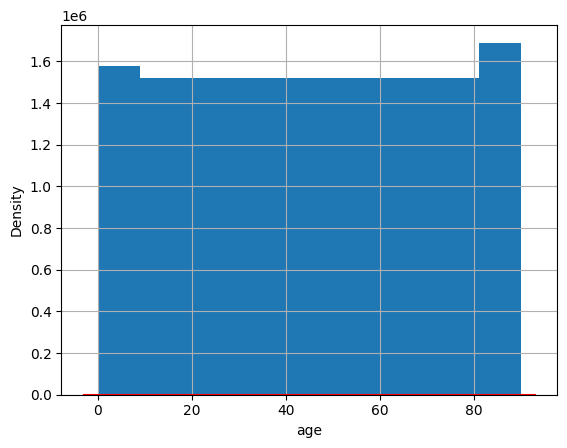

In [16]:
#display age range histogram
combined_10yr_fert['age'].hist()
#add distribution line
sns.kdeplot(combined_10yr_fert['age'], color = 'red')

#### Population Consistency Over Time

#### Simple version

In [17]:
# Group by gss_code and sex and check population values over years
population_consistency = combined_10yr_fert.groupby(['gss_code', 'sex', 'year','component'])['value'].sum().reset_index()

# Check for unrealistic fluctuations
fluctuations = population_consistency.groupby(['gss_code', 'sex','component'])['value'].pct_change().abs()
unrealistic_fluctuations = fluctuations[fluctuations > 2]  # Assuming 200% change is too high
print("extreme population fluctuations:\n", unrealistic_fluctuations)


extreme population fluctuations:
 1        24.120000
2         2.232484
8         3.802632
13        2.119658
25       16.022989
           ...    
10749     2.217594
10868    15.162782
10884     3.817943
10908     2.910910
10916     2.113219
Name: value, Length: 402, dtype: float64


#### more complex version

In [18]:
print("Median of fluctuations:", fluctuations.median())

Median of fluctuations: 0.011668574865599912


In [19]:
combined_10yr_fert

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name
0,E09000001,City of London,2012.0,female,0.0,32.0,births,NaN,NaN
1,E09000001,City of London,2012.0,male,0.0,24.0,births,NaN,NaN
2,E09000001,City of London,2013.0,female,0.0,36.0,births,NaN,NaN
3,E09000001,City of London,2013.0,male,0.0,35.0,births,NaN,NaN
4,E09000001,City of London,2014.0,female,0.0,26.0,births,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15428057,E09000033,Westminster,2050.0,male,86.0,16.9,popn,E05013809,Westbourne
15428058,E09000033,Westminster,2050.0,male,87.0,13.3,popn,E05013809,Westbourne
15428059,E09000033,Westminster,2050.0,male,88.0,11.0,popn,E05013809,Westbourne
15428060,E09000033,Westminster,2050.0,male,89.0,9.9,popn,E05013809,Westbourne


##### place ages in bins this will even out large flunctions between age group where the are likely to the unusally high e.i. 18 year olds moving to university

In [20]:
combined_10yr_fert_agebins = combined_10yr_fert.copy()
#for wards
combined_10yr_fert_agebins_wards = combined_10yr_fert_ward.copy()

In [21]:
combined_10yr_fert_agebins['age'] = pd.cut(combined_10yr_fert_agebins['age'], bins=[-1, 18, 30, 40, 50, 60, 70, 80, 89, 90], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-89', '90+'])
#for wards
combined_10yr_fert_agebins_wards['age'] = pd.cut(combined_10yr_fert_agebins_wards['age'], bins=[-1, 18, 30, 40, 50, 60, 70, 80, 89, 90], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-89', '90+'])

In [62]:
combined_10yr_fert_agebins

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name
0,E09000001,City of London,2012.0,female,0-18,32.0,births,NaN,NaN
1,E09000001,City of London,2012.0,male,0-18,24.0,births,NaN,NaN
2,E09000001,City of London,2013.0,female,0-18,36.0,births,NaN,NaN
3,E09000001,City of London,2013.0,male,0-18,35.0,births,NaN,NaN
4,E09000001,City of London,2014.0,female,0-18,26.0,births,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15428057,E09000033,Westminster,2050.0,male,81-89,16.9,popn,E05013809,Westbourne
15428058,E09000033,Westminster,2050.0,male,81-89,13.3,popn,E05013809,Westbourne
15428059,E09000033,Westminster,2050.0,male,81-89,11.0,popn,E05013809,Westbourne
15428060,E09000033,Westminster,2050.0,male,81-89,9.9,popn,E05013809,Westbourne


In [22]:
#group by gss, sex, component age and year
agebin_consistency = combined_10yr_fert_agebins.groupby(['gss_code', 'sex','component', 'age', 'year'])['value'].sum().reset_index()
#repeat for gss_code_ward
agebin_consistency_ward = combined_10yr_fert_agebins_wards.groupby(['gss_code_ward', 'sex','component', 'age', 'year'])['value'].sum().reset_index()

C:\Users\user\AppData\Local\Temp\ipykernel_20132\1700967552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agebin_consistency = combined_10yr_fert_agebins.groupby(['gss_code', 'sex','component', 'age', 'year'])['value'].sum().reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_20132\1700967552.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agebin_consistency_ward = combined_10yr_fert_agebins_wards.groupby(['gss_code_ward', 'sex','component', 'age', 'year'])['value'].sum().reset_index()


In [23]:
agebin_consistency.head(20)

,gss_code,sex,component,age,year,value
0,E09000001,female,births,0-18,2002.0,0.0
1,E09000001,female,births,0-18,2003.0,0.0
2,E09000001,female,births,0-18,2004.0,0.0
3,E09000001,female,births,0-18,2005.0,0.0
4,E09000001,female,births,0-18,2006.0,0.0
5,E09000001,female,births,0-18,2007.0,0.0
6,E09000001,female,births,0-18,2008.0,0.0
7,E09000001,female,births,0-18,2009.0,0.0
8,E09000001,female,births,0-18,2010.0,0.0
9,E09000001,female,births,0-18,2011.0,0.0


#### --------------------------------------------  remove section below, better method below it

In [24]:
# produce fluctuations unrealistic fluctuations
fluctuations = agebin_consistency.groupby(['gss_code', 'sex','component','age'])['value'].pct_change().abs()

C:\Users\user\AppData\Local\Temp\ipykernel_20132\1379551828.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fluctuations = agebin_consistency.groupby(['gss_code', 'sex','component','age'])['value'].pct_change().abs()


In [25]:
# Handling inf: Replace inf values with NaN
fluctuations.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
# Add the fluctuations back to the DataFrame for easier group-wise operation
agebin_consistency['fluctuations'] = fluctuations

In [27]:
agebin_consistency

,gss_code,sex,component,age,year,value,fluctuations
0,E09000001,female,births,0-18,2002.0,0.0,NaN
1,E09000001,female,births,0-18,2003.0,0.0,NaN
2,E09000001,female,births,0-18,2004.0,0.0,NaN
3,E09000001,female,births,0-18,2005.0,0.0,NaN
4,E09000001,female,births,0-18,2006.0,0.0,NaN
...,...,...,...,...,...,...,...
116419,E09000033,male,popn,90+,2046.0,1503.0,0.040426
116420,E09000033,male,popn,90+,2047.0,1558.7,0.037059
116421,E09000033,male,popn,90+,2048.0,1635.5,0.049272
116422,E09000033,male,popn,90+,2049.0,1701.9,0.040599


###  two methods for determinine unrealisitic flunctuations

#### compare to median fluctuations for each component

In [28]:
#Calculate the median of fluctuations for each 'component'
median_fluctuations_by_component = agebin_consistency.groupby('component')['fluctuations'].median()
print("Median of fluctuations by component:\n", median_fluctuations_by_component)

Median of fluctuations by component:
 component
births     0.005618
deaths     0.018946
netflow    0.085106
popn       0.010314
Name: fluctuations, dtype: float64


In [29]:
#Determine extreme cases by comparing each fluctuation to its component's median# We consider an extreme case where the fluctuation is greater than 3 times the median
extreme_cases = agebin_consistency.groupby('component').apply(lambda x: x[x['fluctuations'] > 10 * median_fluctuations_by_component[x.name]] ).reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_20132\3513562880.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_cases = agebin_consistency.groupby('component').apply(lambda x: x[x['fluctuations'] > 10 * median_fluctuations_by_component[x.name]] ).reset_index(drop=True)


###  --------------------------------------------

#### Seperate components and determine percentage difference between years

In [59]:
agebin_consistency

,gss_code,sex,component,age,year,value,fluctuations
0,E09000001,female,births,0-18,2002.0,0.0,NaN
1,E09000001,female,births,0-18,2003.0,0.0,NaN
2,E09000001,female,births,0-18,2004.0,0.0,NaN
3,E09000001,female,births,0-18,2005.0,0.0,NaN
4,E09000001,female,births,0-18,2006.0,0.0,NaN
...,...,...,...,...,...,...,...
116419,E09000033,male,popn,90+,2046.0,1503.0,0.040426
116420,E09000033,male,popn,90+,2047.0,1558.7,0.037059
116421,E09000033,male,popn,90+,2048.0,1635.5,0.049272
116422,E09000033,male,popn,90+,2049.0,1701.9,0.040599


In [30]:
#remove comparisons between different componenet types
# Pivot the table so that each component's values for each year are in separate columns
pivoted = agebin_consistency.pivot_table(index=['gss_code', 'sex', 'age','year'], columns='component', values='value').reset_index()
#Pivot ward
pivoted_ward = agebin_consistency_ward.pivot_table(index=['gss_code_ward','sex', 'age','year'], columns='component', values='value').reset_index()


C:\Users\user\AppData\Local\Temp\ipykernel_20132\3734378976.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = agebin_consistency.pivot_table(index=['gss_code', 'sex', 'age','year'], columns='component', values='value').reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3734378976.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted_ward = agebin_consistency_ward.pivot_table(index=['gss_code_ward','sex', 'age','year'], columns='component', values='value').reset_index()


In [31]:
pivoted[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted.groupby(['gss_code', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']].pct_change().abs()
pivoted_ward[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted_ward.groupby(['gss_code_ward', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']].pct_change().abs()

C:\Users\user\AppData\Local\Temp\ipykernel_20132\3281309342.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivoted[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted.groupby(['gss_code', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']].pct_change().abs()
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3281309342.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivoted_ward[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted_ward.groupby(['gss_code_ward', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']

#### Handle inf values

##### Exctract from dataframe and use component value to determine outliers

#### visualise distribution and count of inf 

In [32]:
def count_inf_values_and_plot_histograms(df, component_columns, pct_change_columns):
    """
    Prints the count of infinite values in each specified percentage change column and plots histograms for the 
    corresponding value columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing percentage change columns and value columns.
    component_columns (str or list): A single column name or a list of column names to be analysed.
    pct_change_columns (str or list): A single column name or a list of column names (with '_pct_change') to be analysed.
    """
    # If a single column name is provided as a string, convert it to a list
    if isinstance(component_columns, str):
        component_columns = [component_columns]
    if isinstance(pct_change_columns, str):
        pct_change_columns = [pct_change_columns]

    print("Count of inf values in each percentage change column:")
    
    for comp_col, pct_change_col in zip(component_columns, pct_change_columns):
        if pct_change_col in df.columns:
            # Count inf values
            inf_count = df[pct_change_col].isin([np.inf, -np.inf]).sum()
            print(f"{pct_change_col}: {inf_count}")
            
            # Filter rows with inf values
            inf_rows = df[df[pct_change_col].isin([np.inf, -np.inf])]
            
            if comp_col in df.columns:
                if not inf_rows.empty:
                    # Plot histogram
                    inf_rows[comp_col].hist(bins=10)
                    plt.title(f"Histogram of {comp_col.capitalize()}")
                    plt.xlabel(comp_col.capitalize())
                    plt.ylabel("Frequency")
                    plt.show()
            else:
                print(f"No corresponding value column found for {pct_change_col}")
        else:
            print(f"{pct_change_col} does not exist in DataFrame")

# Example usage
# df = pd.read_csv('your_data.csv')  # Load your DataFrame
# count_inf_values_and_plot_histograms(df, ['births', 'deaths', 'netflow', 'popn'], ['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change'])

In [33]:
component_columns = ['births', 'deaths', 'netflow', 'popn']
pct_change_columns = ['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']

Count of inf values in each percentage change column:
births_pct_change: 1361


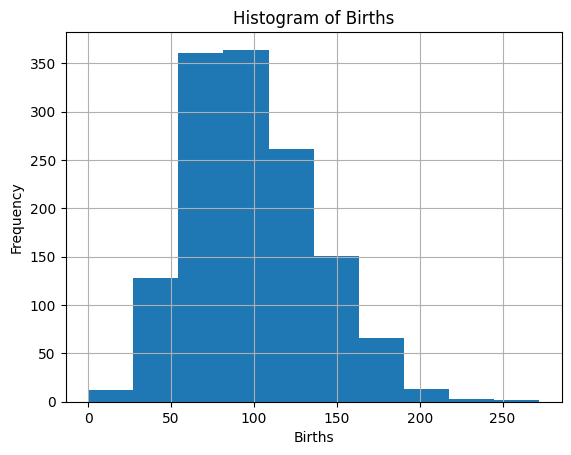

deaths_pct_change: 23629


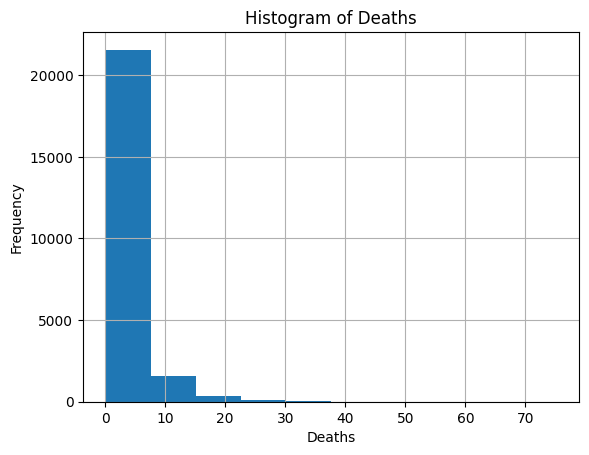

netflow_pct_change: 13636


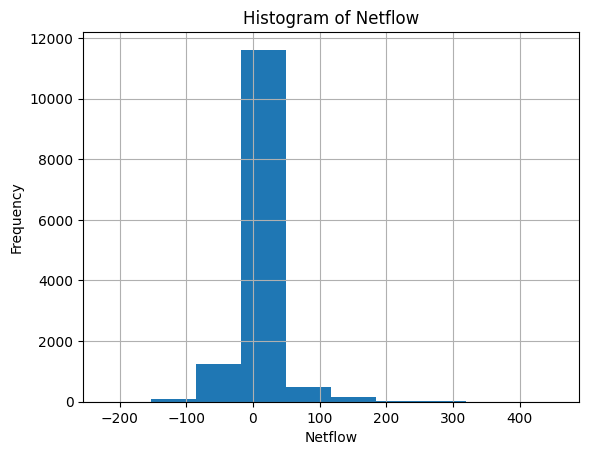

popn_pct_change: 2


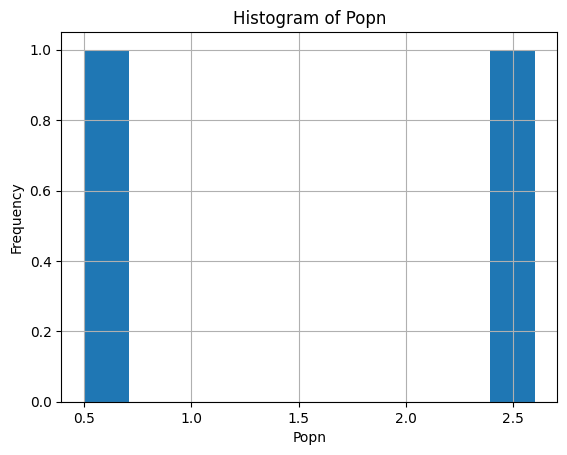

In [34]:
count_inf_values_and_plot_histograms(pivoted_ward, component_columns, pct_change_columns)

Count of inf values in each percentage change column:
births_pct_change: 66


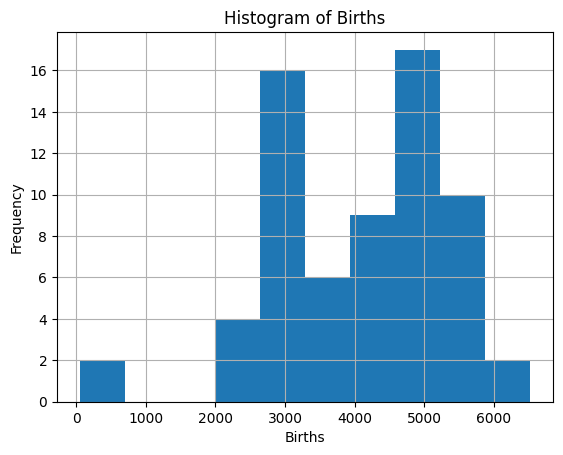

deaths_pct_change: 747


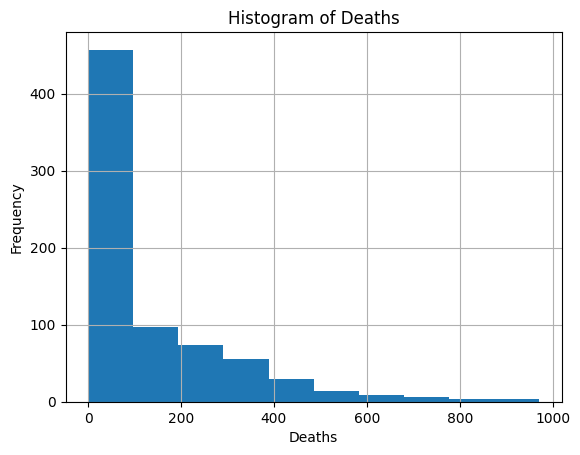

netflow_pct_change: 16


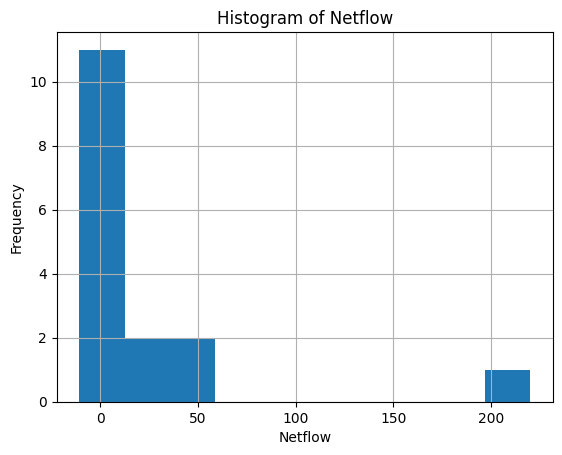

popn_pct_change: 594


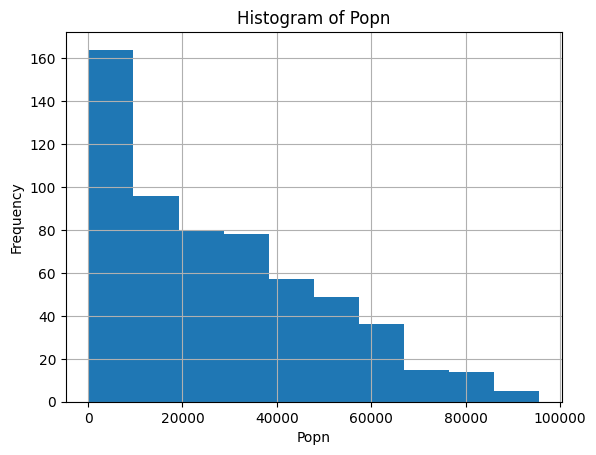

In [35]:
count_inf_values_and_plot_histograms(pivoted, component_columns, pct_change_columns)

In [36]:
def calculate_zscores_and_find_outliers_for_inf(df, component_columns, pct_change_columns):
    """
    Filters rows where the percentage change columns have infinite values, computes z-scores or robust z-scores (depending on distribution )for the respective columns,
    and returns DataFrames containing outliers for the specified component columns based on a z-score threshold.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing population data component value columns as well as separate columns for the respective component value percentage changes from year to year.
    component_columns (str or list): A single column name or a list of column names to be analysed.
    pct_change_columns (str or list): A single column name or a list of column names (with '_pct_change') to be analysed.

    Returns:
    dict: A dictionary containing DataFrames with outliers for each component column.
           
    Example:
    outliers_dict = calculate_zscores_and_find_outliers_for_inf(df, ['births', 'deaths', 'netflow', 'popn'], 
                                                                ['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change'])
    """
    # If a single column name is provided as a string, convert it to a list, so this can work for df with mutiple components or just one
    if isinstance(component_columns, str):
        component_columns = [component_columns]
    if isinstance(pct_change_columns, str):
        pct_change_columns = [pct_change_columns]

    outliers_dict = {}
    z_score_type = {}  # Dictionary to store which method was used

    for comp_col, pct_change_col in zip(component_columns, pct_change_columns):
        if pct_change_col in df.columns:
            # Filter rows where percentage change columns have inf or -inf
            df_inf = df[df[pct_change_col].isin([np.inf, -np.inf])]

            if not df_inf.empty:
                # Check if the column is normally distributed using skewness
                skewness = df_inf[comp_col].skew()

                if abs(skewness) < 0.5: #skew LESS THAn 0.5 WE WILL CONSIDER normal
                    # Use Z-score for normal distribution
                    df_inf['z_score'] = stats.zscore(df_inf[comp_col])
                    outliers = df_inf[df_inf['z_score'].abs() > 2]  # Z-score > 2 is typically considered an outlier
                    z_score_type[comp_col] = 'Normal Z-Score'  # Log which method was used
                    print(f"{comp_col} used Normal Z-Score.")
                else:
                    # Use Robust Z-score (based on median and MAD) for non-normal distribution
                    median = df_inf[comp_col].median()
                    mad = stats.median_abs_deviation(df_inf[comp_col])
                    df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad
                    outliers = df_inf[df_inf['robust_z_score'].abs() > 2]  # Robust Z-score > 2 is considered an outlier
                    z_score_type[comp_col] = 'Robust Z-Score'  # Log which method was used
                    print(f"{comp_col} used Robust Z-Score.")

                # Store the outliers for this component column
                outliers_dict[comp_col] = outliers
            else:
                outliers_dict[comp_col] = pd.DataFrame()  # Return empty DataFrame if no rows found
                #print(z_score_type)
        else:
            print(f"{pct_change_col} does not exist in DataFrame")

    return outliers_dict,  # Returning z_score_type for further use if needed



In [37]:
outliers_dict_inf_ward = calculate_zscores_and_find_outliers_for_inf(pivoted_ward, component_columns, pct_change_columns)


C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

births used Robust Z-Score.
deaths used Robust Z-Score.
netflow used Robust Z-Score.
popn used Robust Z-Score.


C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad


In [38]:
outliers_dict_inf = calculate_zscores_and_find_outliers_for_inf(pivoted, component_columns, pct_change_columns)

births used Robust Z-Score.
deaths used Robust Z-Score.
netflow used Robust Z-Score.
popn used Robust Z-Score.


C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['robust_z_score'] = (df_inf[comp_col] - median) / mad
C:\Users\user\AppData\Local\Temp\ipykernel_20132\3150986119.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [39]:
#access only element in tuple
data_dict_ward = outliers_dict_inf_ward[0]
# Save the DataFrames to the new variables
outliers_births_wards = data_dict_ward['births']
outliers_deaths_wards = data_dict_ward['deaths']
outliers_netflow_wards = data_dict_ward['netflow']
outliers_popn_wards = data_dict_ward['popn']

#for boroughs

#access only element in tuple
data_dict = outliers_dict_inf[0]
# Save the DataFrames to the new variables
outliers_births = data_dict['births']
outliers_deaths = data_dict['deaths']
outliers_netflow = data_dict['netflow']
outliers_popn = data_dict['popn']



In [40]:
outliers_births_wards

component,gss_code_ward,sex,age,year,births,deaths,netflow,popn,births_pct_change,deaths_pct_change,netflow_pct_change,popn_pct_change,robust_z_score
1,E05009317,female,0-18,2012.0,153.4,0.0,15.9,2248.8,inf,NaN,inf,0.001066,2.258555
361,E05009317,male,0-18,2012.0,157.7,0.0,11.6,2369.1,inf,NaN,inf,0.007870,2.422053
5761,E05009325,female,0-18,2012.0,154.5,2.7,58.0,2454.4,inf,inf,inf,0.049248,2.300380
6121,E05009325,male,0-18,2012.0,164.7,1.0,44.4,2550.0,inf,inf,inf,0.040944,2.688213
7201,E05009327,female,0-18,2012.0,172.9,0.7,0.8,2282.3,inf,inf,inf,0.032154,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
485281,E05014115,female,0-18,2012.0,159.3,1.3,-31.9,1517.2,inf,inf,inf,0.043323,2.482890
485641,E05014115,male,0-18,2012.0,148.4,1.1,-31.8,1489.8,inf,inf,inf,0.035302,2.068441
487801,E05014118,male,0-18,2012.0,37.1,0.0,26.9,571.1,inf,NaN,inf,0.038552,-2.163498
488881,E09000001,female,0-18,2012.0,32.0,0.0,12.0,387.0,inf,NaN,inf,0.048780,-2.357414


#### ----------------------------------------- remove older version of the function below

In [41]:
# old version of function to be kept temperarely 
# Function to calculate z-scores and return DataFrames with outliers
def calculate_zscores_and_find_outliers(df):
    """
    Filters rows where the percentage change columns have infinite values, computes z-scores for the respective columns,
    and returns DataFrames containing outliers for births, deaths, netflow, and population based on a z-score threshold.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing population data component value columns as well as seperate columns for the respective component value percentage changes from year to year

    Returns:
    tuple: Four DataFrames containing rows with infinite values, z-scores, and outliers for births, deaths, 
           netflow, and population.
           
    Example:
    outliers_births, outliers_deaths, outliers_netflow, outliers_popn = calculate_zscores_and_find_outliers(df)

    """
    # Filter rows where percentage change columns have inf or -inf
    df_inf_births = df[df['births_pct_change'].isin([np.inf, -np.inf])]
    df_inf_deaths = df[df['deaths_pct_change'].isin([np.inf, -np.inf])]
    df_inf_netflow = df[df['netflow_pct_change'].isin([np.inf, -np.inf])]
    df_inf_popn = df[df['popn_pct_change'].isin([np.inf, -np.inf])]

    # Define a function to calculate outliers based on z-scores
    def calculate_outliers(df_inf, column_name):
        if not df_inf.empty:
            # Calculate mean and standard deviation
            mean = df_inf[column_name].mean()
            std = df_inf[column_name].std()
            # Calculate the threshold (mean + 2 * std)
            threshold = mean + 2 * std
            # Add z-score column
            df_inf['z_score'] = stats.zscore(df_inf[column_name])
            # Filter outliers where z_score > threshold
            outliers = df_inf[df_inf['z_score'].abs() > threshold]
            return outliers
        else:
            return pd.DataFrame()  # Return empty DataFrame if no rows found

    # Calculate outliers for each DataFrame
    outliers_births = calculate_outliers(df_inf_births, 'births')
    outliers_deaths = calculate_outliers(df_inf_deaths, 'deaths')
    outliers_netflow = calculate_outliers(df_inf_netflow, 'netflow')
    outliers_popn = calculate_outliers(df_inf_popn, 'popn')

    # Return the DataFrames with outliers
    return outliers_births, outliers_deaths, outliers_netflow, outliers_popn
#example outliers_births_inf, outliers_deaths_inf, outliers_netflow_inf, outliers_popn_inf = calculate_zscores_and_find_outliers(df)



In [42]:
outliers_births_inf, outliers_deaths_inf, outliers_netflow_inf, outliers_popn_inf = calculate_zscores_and_find_outliers(pivoted)
outliers_births_inf_wards, outliers_deaths_inf_wards, outliers_netflow_inf_wards, outliers_popn_inf_wards = calculate_zscores_and_find_outliers(pivoted_ward)

C:\Users\user\AppData\Local\Temp\ipykernel_20132\2229537256.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['z_score'] = stats.zscore(df_inf[column_name])
C:\Users\user\AppData\Local\Temp\ipykernel_20132\2229537256.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inf['z_score'] = stats.zscore(df_inf[column_name])
C:\Users\user\AppData\Local\Temp\ipykernel_20132\2229537256.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

#### -------------------------------------------------------------------------------------------

#### Continue to the rest of the data that is not inf

In [43]:
def calculate_zscores_and_find_outliers(df, component_columns, pct_change_columns):
    """
    Computes z-scores or robust z-scores (depending on distribution) for the respective columns,
    and returns DataFrames containing outliers for the specified component columns based on a z-score threshold.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing population data component value columns as well as 
                       separate columns for the respective component value percentage changes from year to year.
    component_columns (str or list): A single column name or a list of column names to be analysed.
    pct_change_columns (str or list): A single column name or a list of column names (with '_pct_change') to be analysed.

    Returns:
    dict: A dictionary containing DataFrames with outliers for each component column.
           
    Example:
    outliers_dict = calculate_zscores_and_find_outliers(df, ['births', 'deaths', 'netflow', 'popn'], 
                                                        ['births_pct_change', 'deaths_pct_change', 
                                                         'netflow_pct_change', 'popn_pct_change'])
    """
    # If a single column name is provided as a string, convert it to a list
    if isinstance(component_columns, str):
        component_columns = [component_columns]
    if isinstance(pct_change_columns, str):
        pct_change_columns = [pct_change_columns]

    outliers_dict = {}
    z_score_type = {}  # Dictionary to store which method was used

    for comp_col, pct_change_col in zip(component_columns, pct_change_columns):
        if pct_change_col in df.columns:
            # Replace inf and -inf with NaN
            df_cleaned = df.replace([np.inf, -np.inf], np.nan)
            
            # Drop rows where the component column or the percentage change column has NaN
            df_cleaned = df_cleaned.dropna(subset=[comp_col, pct_change_col])

            if not df_cleaned.empty:
                # Check if the column is normally distributed using skewness
                skewness = df_cleaned[comp_col].skew()

                if abs(skewness) < 0.5:  # If skewness is less than 0.5, use normal Z-score
                    # Use Z-score for normal distribution
                    df_cleaned['z_score'] = stats.zscore(df_cleaned[comp_col])
                    outliers = df_cleaned[df_cleaned['z_score'].abs() > 2]  # Z-score > 2 is typically considered an outlier
                    z_score_type[comp_col] = 'Normal Z-Score'
                    print(f"{comp_col} used Normal Z-Score.")
                else:
                    # Use Robust Z-score (based on median and MAD) for non-normal distribution
                    median = df_cleaned[comp_col].median()
                    mad = stats.median_abs_deviation(df_cleaned[comp_col])
                    df_cleaned['robust_z_score'] = (df_cleaned[comp_col] - median) / mad
                    outliers = df_cleaned[df_cleaned['robust_z_score'].abs() > 2]  # Robust Z-score > 2 is considered an outlier
                    z_score_type[comp_col] = 'Robust Z-Score'
                    print(f"{comp_col} used Robust Z-Score.")

                # Store the outliers for this component column
                outliers_dict[comp_col] = outliers
            else:
                outliers_dict[comp_col] = pd.DataFrame()  # Return empty DataFrame if no rows found
        else:
            print(f"{pct_change_col} does not exist in DataFrame")

    return outliers_dict, z_score_type  # Returning z_score_type for further use if needed


#### Improve with argument to toggle inf

In [44]:
def calculate_zscores_and_find_outliers(df, component_columns, pct_change_columns, handle_inf=True):
    """
    Computes z-scores or robust z-scores (depending on distribution) for the respective columns,
    and returns DataFrames containing outliers for the specified component columns based on a z-score threshold.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing population data component value columns as well as 
                       separate columns for the respective component value percentage changes from year to year.
    component_columns (str or list): A single column name or a list of column names to be analysed.
    pct_change_columns (str or list): A single column name or a list of column names (with '_pct_change') to be analysed.
    handle_inf (bool): If True, only handles rows with 'inf' or '-inf' values in the percentage change columns.
                       If False, works on the entire DataFrame.
    
    Returns:
    dict: A dictionary containing DataFrames with outliers for each component column.
           
    Example:
    outliers_dict = calculate_zscores_and_find_outliers(df, ['births', 'deaths', 'netflow', 'popn'], 
                                                        ['births_pct_change', 'deaths_pct_change', 
                                                         'netflow_pct_change', 'popn_pct_change'], handle_inf=True)
    """
    # If a single column name is provided as a string, convert it to a list
    if isinstance(component_columns, str):
        component_columns = [component_columns]
    if isinstance(pct_change_columns, str):
        pct_change_columns = [pct_change_columns]

    outliers_dict = {}
    z_score_type = {}  # Dictionary to store which method was used

    for comp_col, pct_change_col in zip(component_columns, pct_change_columns):
        if pct_change_col in df.columns:
            if handle_inf:
                # Filter rows where percentage change columns have inf or -inf
                df_filtered = df[df[pct_change_col].isin([np.inf, -np.inf])]
            else:
                # Replace inf and -inf with NaN and work on entire DataFrame after cleaning
                df_filtered = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[comp_col, pct_change_col])

            if not df_filtered.empty:
                # Check if the column is normally distributed using skewness
                skewness = df_filtered[comp_col].skew()

                if abs(skewness) < 0.5:  # If skewness is less than 0.5, use normal Z-score
                    # Use Z-score for normal distribution
                    df_filtered['z_score'] = stats.zscore(df_filtered[comp_col])
                    outliers = df_filtered[df_filtered['z_score'].abs() > 2]  # Z-score > 2 is typically considered an outlier
                    z_score_type[comp_col] = 'Normal Z-Score'
                    print(f"{comp_col} used Normal Z-Score.")
                else:
                    # Use Robust Z-score (based on median and MAD) for non-normal distribution
                    median = df_filtered[comp_col].median()
                    mad = stats.median_abs_deviation(df_filtered[comp_col])
                    df_filtered['robust_z_score'] = (df_filtered[comp_col] - median) / mad
                    outliers = df_filtered[df_filtered['robust_z_score'].abs() > 2]  # Robust Z-score > 2 is considered an outlier
                    z_score_type[comp_col] = 'Robust Z-Score'
                    print(f"{comp_col} used Robust Z-Score.")

                # Store the outliers for this component column
                outliers_dict[comp_col] = outliers
            else:
                outliers_dict[comp_col] = pd.DataFrame()  # Return empty DataFrame if no rows found
        else:
            print(f"{pct_change_col} does not exist in DataFrame")

    return outliers_dict, z_score_type  # Returning z_score_type for further use if needed


#### Toggle for geographic area, ward or borough

In [57]:
def calculate_zscores_and_find_outliers(df, component_columns, pct_change_columns, level='borough', handle_inf=True):
    """
    Computes z-scores or robust z-scores for the specified component columns, depending on distribution and returns DataFrames
    containing outliers based on a z-score threshold. The analysis can be grouped by wards (gss_code_ward) or 
    boroughs (gss_code). It handles both infinite values or the full dataset based on the argument.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing data for components like births, deaths, etc.
    component_columns (str or list): Column name or list of component columns to analyse (e.g., 'births', 'deaths').
    pct_change_columns (str or list): Column name or list of percentage change columns (e.g., 'births_pct_change').
    level (str): Determines whether to group by 'borough' (gss_code) or 'ward' (gss_code_ward). Default is 'borough'.
    handle_inf (bool): If True, filters rows with infinite values in percentage change columns; if False, operates on the entire dataset.

    Returns:
    dict: A dictionary containing DataFrames of outliers for each component column.
    
    Example:
    outliers_dict = calculate_zscores_and_find_outliers(
        df, ['births', 'deaths'], 
        ['births_pct_change', 'deaths_pct_change'], 
        level='ward', handle_inf=True
    )
    """
    # If a single column name is provided, convert it to a list
    if isinstance(component_columns, str):
        component_columns = [component_columns]
    if isinstance(pct_change_columns, str):
        pct_change_columns = [pct_change_columns]

    # Choose grouping column based on level
    if level == 'ward':
        grouping_column = 'gss_code_ward'
    elif level == 'borough':
        grouping_column = 'gss_code'
    else:
        raise ValueError("Invalid level. Choose either 'borough' or 'ward'.")

    outliers_dict = {}
    z_score_type = {}  # To store which z-score method was used (normal or robust)

    for comp_col, pct_change_col in zip(component_columns, pct_change_columns):
        if pct_change_col in df.columns:
            # Handle inf values if specified
            if handle_inf:
                df_filtered = df[df[pct_change_col].isin([np.inf, -np.inf])]
            else:
                df_filtered = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[comp_col, pct_change_col])

            if not df_filtered.empty:
                # Group by wards or boroughs
                grouped = df_filtered.groupby(grouping_column)

                outliers_list = []
                for name, group in grouped:
                    # Check distribution skewness to determine z-score method
                    skewness = group[comp_col].skew()

                    if abs(skewness) < 0.5:
                        # Normal distribution: Use regular z-scores
                        group['z_score'] = stats.zscore(group[comp_col])
                        outliers = group[group['z_score'].abs() > 2]  # Z-score > 2 is an outlier
                        z_score_type[comp_col] = 'Normal Z-Score'
                    else:
                        # Non-normal distribution: Use robust z-scores
                        median = group[comp_col].median()
                        mad = stats.median_abs_deviation(group[comp_col])
                        group['robust_z_score'] = (group[comp_col] - median) / mad
                        outliers = group[group['robust_z_score'].abs() > 2]  # Robust Z-score > 2
                        z_score_type[comp_col] = 'Robust Z-Score'

                    outliers_list.append(outliers)

                # Concatenate the outliers for each group and store in the result dictionary
                outliers_dict[comp_col] = pd.concat(outliers_list, ignore_index=True)
            else:
                outliers_dict[comp_col] = pd.DataFrame()  # Empty DataFrame if no valid data

        else:
            print(f"Column {pct_change_col} does not exist in DataFrame")

    return outliers_dict, z_score_type


##### the function above needs to be fix with the addtion of the  of the below

In [ ]:
#group by gss, sex, component age and year
agebin_consistency = combined_10yr_fert_agebins.groupby(['gss_code', 'sex','component', 'age', 'year'])['value'].sum().reset_index()
#repeat for gss_code_ward
agebin_consistency_ward = combined_10yr_fert_agebins_wards.groupby(['gss_code_ward', 'sex','component', 'age', 'year'])['value'].sum().reset_index()

#remove comparisons between different componenet types
# Pivot the table so that each component's values for each year are in separate columns
pivoted = agebin_consistency.pivot_table(index=['gss_code', 'sex', 'age','year'], columns='component', values='value').reset_index()
#Pivot ward
pivoted_ward = agebin_consistency_ward.pivot_table(index=['gss_code_ward','sex', 'age','year'], columns='component', values='value').reset_index()

pivoted[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted.groupby(['gss_code', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']].pct_change().abs()
pivoted_ward[['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']] = pivoted_ward.groupby(['gss_code_ward', 'sex', 'age'])[['births', 'deaths', 'netflow', 'popn']].pct_change().abs()

#### determine the mode and mean of percentage change columns

In [48]:
def view_descriptive_statistics(df, columns):
    """
    Calculate descriptive statistics, including mean, median, and mode, for specified columns in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of columns for which to calculate the statistics.
    
    Returns:
    pd.DataFrame: DataFrame containing the descriptive statistics including median and mode.
    """
    # Get descriptive statistics using describe()
    descriptive_stats = df[columns].describe()

    # Calculate median for each column
    median = df[columns].median()

    # Calculate mode for each column (in case of multiple modes, take the first one)
    mode = df[columns].mode().iloc[0]

    # Add median and mode to the descriptive statistics DataFrame
    descriptive_stats.loc['median'] = median
    descriptive_stats.loc['mode'] = mode

    # Return the combined descriptive statistics
    return descriptive_stats


In [49]:
# List of percentage change columns
pct_change_columns = ['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']

# Call the function
descriptive_stats = view_descriptive_statistics(pivoted, pct_change_columns)

# Display the descriptive statistics
print(descriptive_stats)

component  births_pct_change  deaths_pct_change  netflow_pct_change  \
count            2574.000000       2.297000e+04        2.851200e+04   
mean                     inf                inf                 inf   
std                      NaN                NaN                 NaN   
min                 0.000000       0.000000e+00        0.000000e+00   
25%                 0.002880       8.629751e-03        2.087822e-02   
50%                 0.005754       1.996800e-02        8.522126e-02   
75%                 0.018436       6.809543e-02        4.355508e-01   
max                      inf                inf                 inf   
median              0.005754       1.996800e-02        8.522126e-02   
mode                     inf       0.000000e+00        0.000000e+00   

component  popn_pct_change  
count         2.376000e+04  
mean                   inf  
std                    NaN  
min           0.000000e+00  
25%           4.342758e-03  
50%           1.071374e-02  
75%           2

c:\Users\user\anaconda3\envs\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\user\anaconda3\envs\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\user\anaconda3\envs\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\user\anaconda3\envs\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


#### This is the development version below keep until review update, compare output from different functions ---------------------------------------------

In [50]:
def identify_outliers_for_components(df):
    """
    Identifies outliers based on percentage change columns and flags them if they exceed
    calculated thresholds. Returns DataFrames for outliers in each column and for rows
    where all percentage change flags are True.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing percentage change columns.
    
    Returns:
    tuple: DataFrames for outliers in births, deaths, netflow, population, and all components.
    """
    # Define the percentage change columns
    pct_change_columns = ['births_pct_change', 'deaths_pct_change', 'netflow_pct_change', 'popn_pct_change']
    
    # Check if DataFrame contains all necessary columns
    if not all(col in df.columns for col in pct_change_columns):
        raise ValueError("DataFrame must contain all specified columns: " + ", ".join(pct_change_columns))
    
    # Calculate means and standard deviations
    means = df[pct_change_columns].mean()
    stds = df[pct_change_columns].std()
    
    # Set thresholds as mean ± 2 * std
    thresholds = means + 2 * stds
    
    # Create a copy of the DataFrame to flag outliers
    df_outliers = df.copy()
    
    # Flag rows where the percentage change exceeds the thresholds
    for col in pct_change_columns:
        threshold = thresholds[col]
        df_outliers[f'flag_{col}'] = df_outliers[col].abs() > threshold
    
    # Create DataFrames for outliers in each column
    births_outliers = df_outliers[df_outliers['flag_births_pct_change']]
    deaths_outliers = df_outliers[df_outliers['flag_deaths_pct_change']]
    netflow_outliers = df_outliers[df_outliers['flag_netflow_pct_change']]
    popn_outliers = df_outliers[df_outliers['flag_popn_pct_change']]
    
    # Create DataFrame for rows where all flags are True
    all_components_outliers = df_outliers[
        (df_outliers['flag_births_pct_change']) &
        (df_outliers['flag_deaths_pct_change']) &
        (df_outliers['flag_netflow_pct_change']) &
        (df_outliers['flag_popn_pct_change'])
    ]
    
    return births_outliers, deaths_outliers, netflow_outliers, popn_outliers, all_components_outliers

# Example usage
# Assuming 'pivoted' is your input DataFrame
# births_outliers, deaths_outliers, netflow_outliers, popn_outliers, all_components_outliers = identify_outliers_for_components(pivoted)


---------------------------------------------------------------------------------

In [51]:
births_outliers, deaths_outliers, netflow_outliers, popn_outliers, all_components_outliers = identify_outliers_for_components(pivoted_no_inf)
births_outliers_wards, deaths_outliers_wards, netflow_outliers_wards, popn_outliers_wards, all_components_outliers_wards = identify_outliers_for_components(pivoted_wards_no_inf)

In [52]:
outliers_dict = calculate_zscores_and_find_outliers(pivoted_no_inf, component_columns, pct_change_columns)
outliers_dict_ward = calculate_zscores_and_find_outliers(pivoted_wards_no_inf, component_columns, pct_change_columns)

In [53]:
#access only element in tuple
data_dict_ward = outliers_dict_ward[0]
# Save the DataFrames to the new variables
outliers_births_wards = data_dict_ward['births']
outliers_deaths_wards = data_dict_ward['deaths']
outliers_netflow_wards = data_dict_ward['netflow']
outliers_popn_wards = data_dict_ward['popn']

#for boroughs

#access only element in tuple
data_dict =outliers_dict[0]
# Save the DataFrames to the new variables
outliers_births = data_dict['births']
outliers_deaths = data_dict['deaths']
outliers_netflow = data_dict['netflow']
outliers_popn = data_dict['popn']

In [54]:
outliers_births_wards 

""


#### now test with the addtional inf toggle arugment


In [56]:
outliers_dict_ward = calculate_zscores_and_find_outliers(pivoted_ward, component_columns, pct_change_columns, handle_inf=False)

KeyError: 'gss_code'

## Total population

##### crossectional comparison, change between boroughs and wards for a given year 
##### temporal comparison, percentage change between years

In [157]:
# Group by 'gss_code' and 'year', and sum the 'popn' values
population_sum = pivoted.groupby(['gss_code', 'year'])['popn'].sum().reset_index()
population_sum_wards = pivoted_ward.groupby(['gss_code_ward', 'year'])['popn'].sum().reset_index()

In [158]:
population_sum_time = population_sum.copy()
population_sum_time_wards = population_sum_wards.copy()

In [159]:
# Temporally: Calculate the population change over the years for each gss_code
population_sum_time['popn_pct_change_temporal'] = population_sum_time.groupby('gss_code')['popn'].pct_change() * 100
population_sum_time_wards['popn_pct_change_temporal'] = population_sum_time_wards.groupby('gss_code_ward')['popn'].pct_change() * 100

# Cross-sectionally: Compare the population between different gss_code for the same year
population_sum_time['popn_pct_change_cross'] = population_sum_time.groupby('year')['popn'].pct_change() * 100
population_sum_time_wards['popn_pct_change_cross'] = population_sum_time_wards.groupby('gss_code_ward')['popn'].pct_change() * 100


#### handle inf seperately 

#### use the count_inf_values_and_plot_histograms function to investigate as this function can handle list of columns as well as individual columns 

In [160]:
count_inf_values_and_plot_histograms(population_sum_time, 'popn', 'popn_pct_change_cross')

Count of inf values in each percentage change column:
popn_pct_change_cross: 0


Count of inf values in each percentage change column:
popn_pct_change_temporal: 33


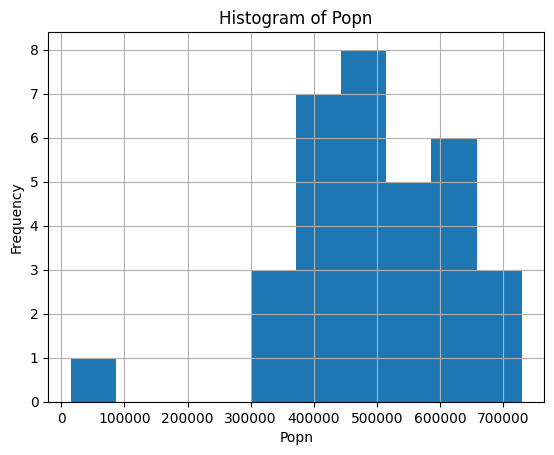

In [161]:
count_inf_values_and_plot_histograms(population_sum_time, 'popn', 'popn_pct_change_temporal')

In [162]:
print(population_sum_time.isin([np.inf, -np.inf]).sum())
print(population_sum_time_wards.isin([np.inf, -np.inf]).sum())

gss_code                     0
year                         0
popn                         0
popn_pct_change_temporal    33
popn_pct_change_cross        0
dtype: int64
gss_code_ward               0
year                        0
popn                        0
popn_pct_change_temporal    0
popn_pct_change_cross       0
dtype: int64


In [204]:
population_sum_time

,gss_code,year,popn,popn_pct_change_temporal,popn_pct_change_cross
0,E09000001,2002.0,0.0,NaN,NaN
1,E09000001,2003.0,0.0,NaN,NaN
2,E09000001,2004.0,0.0,NaN,NaN
3,E09000001,2005.0,0.0,NaN,NaN
4,E09000001,2006.0,0.0,NaN,NaN
...,...,...,...,...,...
1612,E09000033,2046.0,417624.9,0.040483,-38.193566
1613,E09000033,2047.0,417735.3,0.026435,-38.179652
1614,E09000033,2048.0,417785.5,0.012017,-38.165808
1615,E09000033,2049.0,417790.3,0.001149,-38.154196


In [208]:
calculate_zscores_and_find_outliers(population_sum_time,'popn','popn_pct_change_temporal', handle_inf=False)

popn used Robust Z-Score.


({'popn':        gss_code    year      popn  popn_pct_change_temporal  \
  10    E09000001  2012.0   14986.0                  1.188386   
  11    E09000001  2013.0   15050.0                  0.427065   
  12    E09000001  2014.0   15214.0                  1.089701   
  13    E09000001  2015.0   15510.0                  1.945576   
  14    E09000001  2016.0   15684.0                  1.121857   
  ...         ...     ...       ...                       ...   
  1220  E09000025  2046.0  870359.0                  0.062979   
  1221  E09000025  2047.0  870654.7                  0.033974   
  1222  E09000025  2048.0  870778.0                  0.014162   
  1223  E09000025  2049.0  870787.4                  0.001079   
  1224  E09000025  2050.0  870711.9                 -0.008670   
  
        popn_pct_change_cross  robust_z_score  
  10                      NaN       -4.999573  
  11                      NaN       -4.998998  
  12                      NaN       -4.997525  
  13             

In [207]:
calculate_zscores_and_find_outliers(population_sum_time_wards,'popn','popn_pct_change_temporal', handle_inf=False)

popn used Robust Z-Score.


({'popn':       gss_code_ward    year     popn  popn_pct_change_temporal  \
  1         E05009317  2012.0  19740.5                 -0.533097   
  2         E05009317  2013.0  20077.5                  1.707150   
  3         E05009317  2014.0  19892.3                 -0.922426   
  4         E05009317  2015.0  19262.9                 -3.164038   
  5         E05009317  2016.0  20283.3                  5.297229   
  ...             ...     ...      ...                       ...   
  27162     E09000001  2013.0   7525.0                  0.427065   
  27163     E09000001  2014.0   7607.0                  1.089701   
  27164     E09000001  2015.0   7755.0                  1.945576   
  27165     E09000001  2016.0   7842.0                  1.121857   
  27166     E09000001  2017.0   8002.0                  2.040296   
  
         popn_pct_change_cross  robust_z_score  
  1                  -0.533097        2.488132  
  2                   1.707150        2.617670  
  3                  -0.92

#### determine threshold 

In [ ]:
# Calculate the mean and standard deviation of the percentage changes
mean_temporal = df['popn_pct_change_temporal'].mean()
std_temporal = df['popn_pct_change_temporal'].std()

mean_cross = df['popn_pct_change_cross'].mean()
std_cross = df['popn_pct_change_cross'].std()

# Set thresholds as mean ± 2*std (you can adjust the multiplier)
threshold_temporal = mean_temporal + 2 * std_temporal
threshold_cross = mean_cross + 2 * std_cross

# Flag rows where the percentage change exceeds the calculated thresholds
df['flag_temporal'] = df['popn_pct_change_temporal'].abs() > threshold_temporal
df['flag_cross'] = df['popn_pct_change_cross'].abs() > threshold_cross

 

In [ ]:
# DataFrame for rows where only flag_temporal is True
df_temporal_outliers = df[df['flag_temporal'] == True]

# DataFrame for rows where only flag_cross is True
df_cross_outliers = df[df['flag_temporal'] == True]

# DataFrame for rows where both flags are True
df_cross_and_temporal_outliers = df[(df['flag_temporal'] == True) & (df['flag_cross'] == True)]

In [ ]:
df_temporal_outliers

,gss_code,year,popn,popn_pct_change_temporal,popn_pct_change_cross,flag_temporal,flag_cross
16,E09000001,2018.0,16440.0,2.724319,NaN,True,False
17,E09000001,2019.0,17514.0,6.532847,NaN,True,False
18,E09000001,2020.0,16582.0,-5.321457,NaN,True,False
19,E09000001,2021.0,17386.0,4.848631,NaN,True,False
20,E09000001,2022.0,21694.0,24.778557,NaN,True,False
61,E09000002,2014.0,402370.8,2.557497,2544.740371,True,True
62,E09000002,2015.0,413051.4,2.654417,2563.129594,True,True
314,E09000007,2022.0,436098.0,3.357634,-33.839941,True,False
1432,E09000030,2013.0,540646.1,3.199188,37.445736,True,False
1433,E09000030,2014.0,554323.2,2.529769,39.156560,True,False


In [ ]:
df_cross_outliers

,gss_code,year,popn,popn_pct_change_temporal,popn_pct_change_cross,flag_temporal,flag_cross
16,E09000001,2018.0,16440.0,2.724319,NaN,True,False
17,E09000001,2019.0,17514.0,6.532847,NaN,True,False
18,E09000001,2020.0,16582.0,-5.321457,NaN,True,False
19,E09000001,2021.0,17386.0,4.848631,NaN,True,False
20,E09000001,2022.0,21694.0,24.778557,NaN,True,False
61,E09000002,2014.0,402370.8,2.557497,2544.740371,True,True
62,E09000002,2015.0,413051.4,2.654417,2563.129594,True,True
314,E09000007,2022.0,436098.0,3.357634,-33.839941,True,False
1432,E09000030,2013.0,540646.1,3.199188,37.445736,True,False
1433,E09000030,2014.0,554323.2,2.529769,39.156560,True,False


In [ ]:
df_cross_and_temporal_outliers

,gss_code,year,popn,popn_pct_change_temporal,popn_pct_change_cross,flag_temporal,flag_cross
61,E09000002,2014.0,402370.8,2.557497,2544.740371,True,True
62,E09000002,2015.0,413051.4,2.654417,2563.129594,True,True


#### Gender check

In [63]:
combined_10yr_fert_copy =  combined_10yr_fert.copy()

In [73]:
# Create the pivot table
gender_pivot = combined_10yr_fert_copy.pivot_table(
    index=['gss_code', 'year', 'age', 'component'],  # Rows: gss_code, year, age
    columns='sex',                      # Columns: sex (male, female)
    values='value',                     # Values: count of males and females
    aggfunc='sum'                       # Aggregation function: sum
).reset_index()                         # Reset index to flatten the DataFrame

# Calculate the ratio of females to males
# Add a column 'ratio_female_to_male'
gender_pivot['ratio_female_to_male'] = gender_pivot['female'] / gender_pivot['male']

# Handle division by zero and missing values
gender_pivot['ratio_female_to_male'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
gender_pivot['ratio_female_to_male'].fillna('NaN', inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_20132\2095478371.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gender_pivot['ratio_female_to_male'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)


In [74]:
gender_pivot

sex,gss_code,year,age,component,female,male,ratio_female_to_male
0,E09000001,2002.0,0.0,netflow,3.5,-2.0,-1.75
1,E09000001,2002.0,1.0,netflow,2.5,1.0,2.5
2,E09000001,2002.0,2.0,netflow,-0.5,-2.5,0.2
3,E09000001,2002.0,3.0,netflow,-3.5,1.5,-2.333333
4,E09000001,2002.0,4.0,netflow,0.0,0.5,0.0
...,...,...,...,...,...,...,...
385666,E09000033,2050.0,89.0,netflow,-23.2,-19.8,1.171717
385667,E09000033,2050.0,89.0,popn,717.8,456.4,1.572743
385668,E09000033,2050.0,90.0,deaths,453.7,294.3,1.541624
385669,E09000033,2050.0,90.0,netflow,-101.5,-52.3,1.940727


In [75]:
#seperate components into columns
gender_pivot = gender_pivot.pivot(index= ["gss_code", "year", "age"], columns="component", values="ratio_female_to_male").reset_index()


In [78]:
gender_pivot 

component,gss_code,year,age,births,deaths,netflow,popn
0,E09000001,2002.0,0.0,NaN,NaN,-1.75,NaN
1,E09000001,2002.0,1.0,NaN,NaN,2.5,NaN
2,E09000001,2002.0,2.0,NaN,NaN,0.2,NaN
3,E09000001,2002.0,3.0,NaN,NaN,-2.333333,NaN
4,E09000001,2002.0,4.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...
147142,E09000033,2050.0,86.0,NaN,1.173469,1.367089,1.323377
147143,E09000033,2050.0,87.0,NaN,0.787346,1.528662,1.443541
147144,E09000033,2050.0,88.0,NaN,1.20284,0.817021,1.459087
147145,E09000033,2050.0,89.0,NaN,1.286325,1.171717,1.572743


In [79]:
#Convert columns to numeric, forcing errors to NaN (use errors='coerce')
gender_pivot['births'] = pd.to_numeric(gender_pivot['births'], errors='coerce') 
gender_pivot['deaths'] = pd.to_numeric(gender_pivot['deaths'], errors='coerce') 
gender_pivot['netflow'] = pd.to_numeric(gender_pivot['netflow'], errors='coerce') 
gender_pivot['popn'] = pd.to_numeric(gender_pivot['popn'], errors='coerce')

# Calculate the mean and standard deviation for each column
mean_births = gender_pivot['births'].mean()
std_births = gender_pivot['births'].std()

mean_deaths = gender_pivot['deaths'].mean()
std_deaths = gender_pivot['deaths'].std()

mean_netflow = gender_pivot['netflow'].mean()
std_netflow = gender_pivot['netflow'].std()

mean_popn = gender_pivot['popn'].mean()
std_popn = gender_pivot['popn'].std()

# Set thresholds as mean ± 2*std
threshold_births_high = mean_births + 2 * std_births
threshold_births_low = mean_births - 2 * std_births

threshold_deaths_high = mean_deaths + 5 * std_deaths
threshold_deaths_low = mean_deaths - 5 * std_deaths

threshold_netflow_high = mean_netflow + 2 * std_netflow
threshold_netflow_low = mean_netflow - 2 * std_netflow

threshold_popn_high = mean_popn + 5 * std_popn
threshold_popn_low = mean_popn - 5 * std_popn

# Identify outliers for each column
gender_births_outliers = gender_pivot[(gender_pivot['births'] > threshold_births_high) | (gender_pivot['births'] < threshold_births_low)].reset_index()
gender_deaths_outliers = gender_pivot[(gender_pivot['deaths'] > threshold_deaths_high) | (gender_pivot['deaths'] < threshold_deaths_low)].reset_index()
gender_netflow_outliers = gender_pivot[(gender_pivot['netflow'] > threshold_netflow_high) | (gender_pivot['netflow'] < threshold_netflow_low)].reset_index()
gender_popn_outliers = gender_pivot[(gender_pivot['popn'] > threshold_popn_high) | (gender_pivot['popn'] < threshold_popn_low)].reset_index()

In [80]:
gender_births_outliers

component,index,gss_code,year,age,births,deaths,netflow,popn
0,910,E09000001,2012.0,0.0,1.333333,NaN,-1.666667,1.545455
1,1001,E09000001,2013.0,0.0,1.028571,NaN,-0.600000,0.894737
2,1092,E09000001,2014.0,0.0,0.619048,NaN,-0.333333,0.590909
3,1274,E09000001,2016.0,0.0,1.900000,NaN,-0.111111,1.583333
4,1365,E09000001,2017.0,0.0,1.060606,0.000000,5.000000,1.000000
5,1456,E09000001,2018.0,0.0,0.736842,NaN,1.000000,0.722222
6,1547,E09000001,2019.0,0.0,0.828571,NaN,-2.333333,0.722222
7,1638,E09000001,2020.0,0.0,1.222222,NaN,3.000000,1.230769
8,1729,E09000001,2021.0,0.0,0.758621,0.000000,-2.600000,0.533333
9,28483,E09000007,2021.0,0.0,0.878939,NaN,0.052083,0.952209


#### convert above to gender outlier function 

In [84]:
def gender_outliers(df, component_columns, geography='borough', outlier_std={'births': 2, 'deaths': 5, 'netflow': 2, 'popn': 5}):
    """
    Processes gender data for either wards or boroughs, and calculates outliers for specified components.
    
    Parameters:
    - df: pandas DataFrame containing the raw data
    - component_columns: list or single component column name(s) for which ratios and outliers need to be calculated
    - geography: str, either 'ward' or 'borough', default is 'borough'
    - outlier_std: dict specifying how many standard deviations to use for each component's threshold calculation.
    
    Returns:
    - outliers_dict: dictionary of outlier DataFrames for each component
    """

    # Check geography type and set index columns accordingly
    if geography == 'ward':
        geo_col = 'gss_code_ward'
    else:
        geo_col = 'gss_code'
    
    # Step 1: Create the pivot table
    gender_pivot = df.pivot_table(
        index=[geo_col, 'year', 'age', 'component'],  # Geography column and other grouping columns
        columns='sex',                                # Columns for sex (male, female)
        values='value',                               # Values (count of males and females)
        aggfunc='sum'                                 # Aggregation function (sum)
    ).reset_index()
    
    # Step 2: Calculate the ratio of females to males
    gender_pivot['ratio_female_to_male'] = gender_pivot['female'] / gender_pivot['male']
    
    # Handle division by zero and missing values
    gender_pivot['ratio_female_to_male'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    gender_pivot['ratio_female_to_male'].fillna(np.nan, inplace=True)
    
    # Step 3: Pivot again to spread component values into columns
    gender_pivot = gender_pivot.pivot(
        index=[geo_col, 'year', 'age'], 
        columns='component', 
        values='ratio_female_to_male'
    ).reset_index()
    
    # Step 4: Convert the specified component columns to numeric
    for component in component_columns:
        gender_pivot[component] = pd.to_numeric(gender_pivot[component], errors='coerce')
    
    # Step 5: Calculate mean and standard deviation for each component
    means = {}
    stds = {}
    for component in component_columns:
        means[component] = gender_pivot[component].mean()
        stds[component] = gender_pivot[component].std()
    
    # Step 6: Set thresholds for outliers using mean ± specified standard deviations
    thresholds = {}
    for component in component_columns:
        high_threshold = means[component] + outlier_std.get(component, 2) * stds[component]
        low_threshold = means[component] - outlier_std.get(component, 2) * stds[component]
        thresholds[component] = (low_threshold, high_threshold)
    
    # Step 7: Identify outliers for each component
    outliers_dict = {}
    for component in component_columns:
        low_threshold, high_threshold = thresholds[component]
        outliers = gender_pivot[(gender_pivot[component] > high_threshold) | (gender_pivot[component] < low_threshold)]
        outliers_dict[component] = outliers.reset_index(drop=True)
    
    return outliers_dict



In [86]:
gender_outlier_dictionary = process_gender_data(combined_10yr_fert_copy, component_columns, geography='borough', outlier_std={'births': 2, 'deaths': 5, 'netflow': 2, 'popn': 5})

C:\Users\user\AppData\Local\Temp\ipykernel_20132\1586553891.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gender_pivot['ratio_female_to_male'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_20132\1586553891.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

In [88]:
gender_outlier_dictionary

{'births': component   gss_code    year  age    births    deaths   netflow      popn
 0          E09000001  2012.0  0.0  1.333333       NaN -1.666667  1.545455
 1          E09000001  2013.0  0.0  1.028571       NaN -0.600000  0.894737
 2          E09000001  2014.0  0.0  0.619048       NaN -0.333333  0.590909
 3          E09000001  2016.0  0.0  1.900000       NaN -0.111111  1.583333
 4          E09000001  2017.0  0.0  1.060606  0.000000  5.000000  1.000000
 5          E09000001  2018.0  0.0  0.736842       NaN  1.000000  0.722222
 6          E09000001  2019.0  0.0  0.828571       NaN -2.333333  0.722222
 7          E09000001  2020.0  0.0  1.222222       NaN  3.000000  1.230769
 8          E09000001  2021.0  0.0  0.758621  0.000000 -2.600000  0.533333
 9          E09000007  2021.0  0.0  0.878939       NaN  0.052083  0.952209
 10         E09000011  2017.0  0.0  1.040463  0.564263 -0.052925  1.053535
 11         E09000013  2015.0  0.0  1.052862  0.666667  1.130479  1.049819
 12         E09

#### Distributions

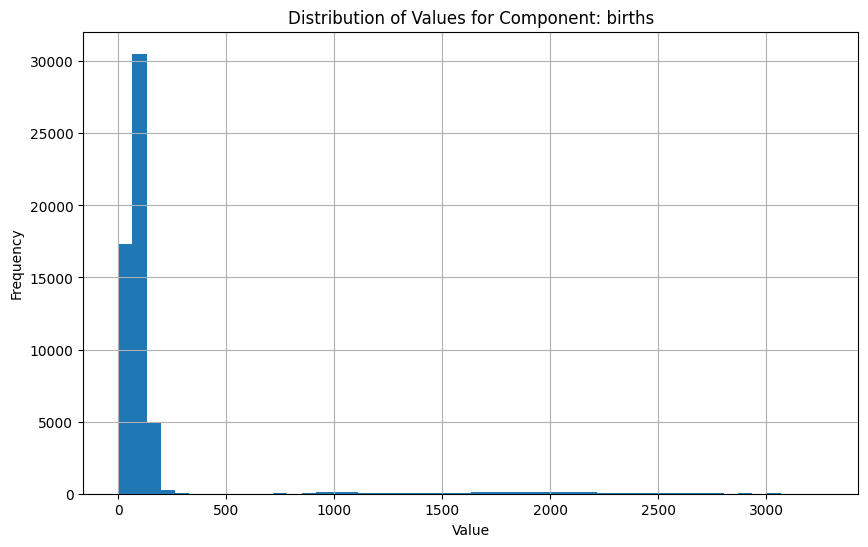

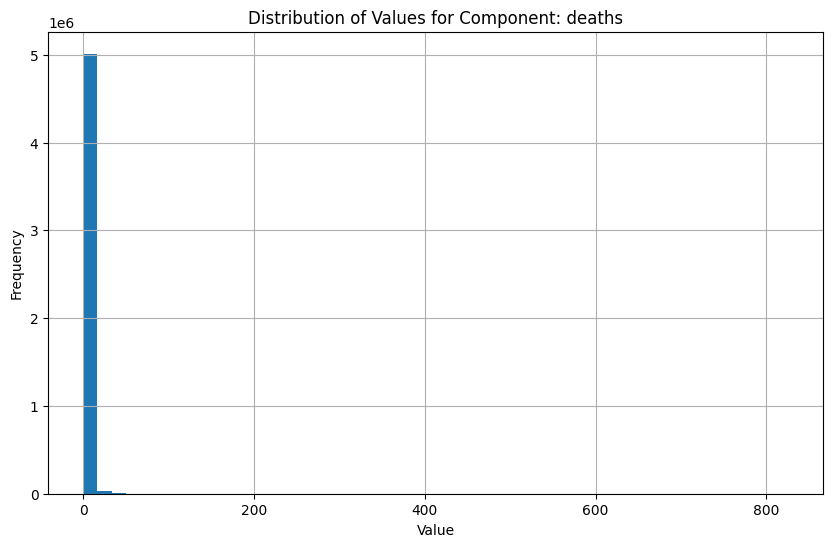

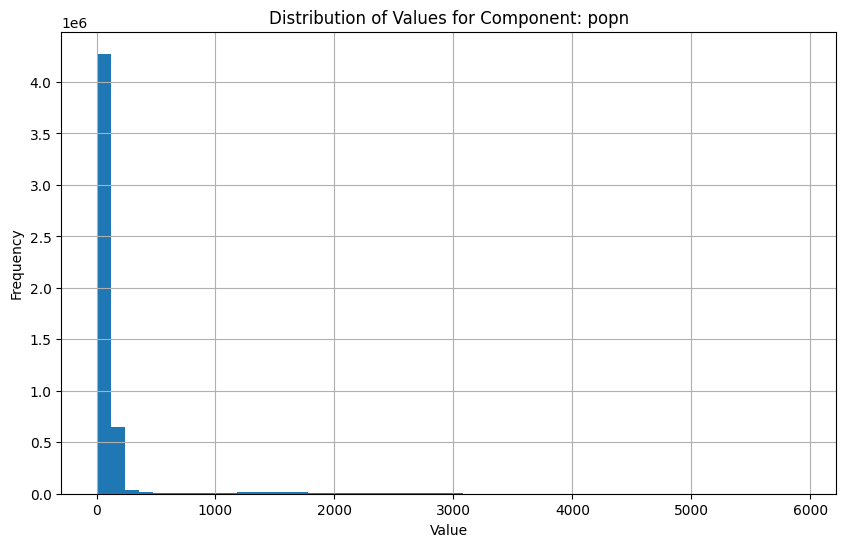

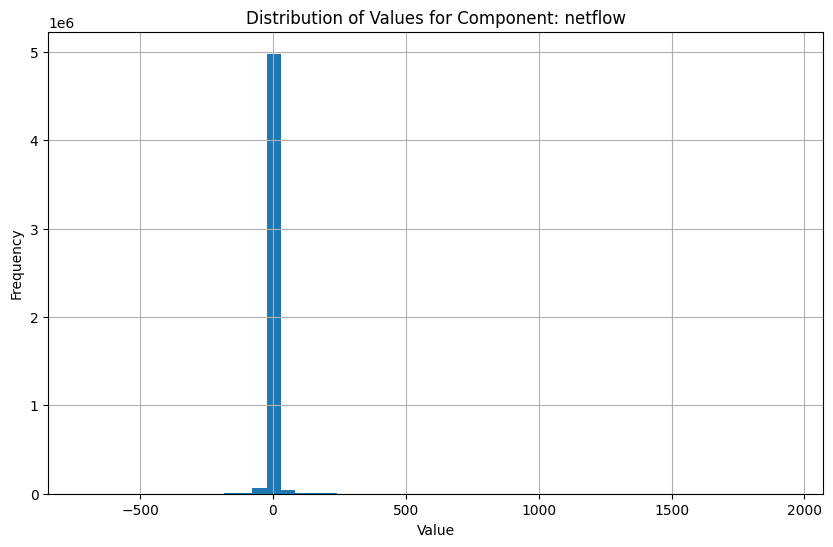

In [ ]:
#distribution of values for each component
components = combined_10yr_fert['component'].unique()

for component in components:
    plt.figure(figsize=(10, 6))
    subset = combined_10yr_fert[combined_10yr_fert['component'] == component]
    subset['value'].hist(bins=50)
    plt.title(f'Distribution of Values for Component: {component}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()


#### components by age

In [ ]:
combined_10yr_fert_age_bins

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name,age_group
0,E09000001,City of London,2012.0,female,0.0,32.0,births,NaN,NaN,0-18
1,E09000001,City of London,2012.0,male,0.0,24.0,births,NaN,NaN,0-18
2,E09000001,City of London,2013.0,female,0.0,36.0,births,NaN,NaN,0-18
3,E09000001,City of London,2013.0,male,0.0,35.0,births,NaN,NaN,0-18
4,E09000001,City of London,2014.0,female,0.0,26.0,births,NaN,NaN,0-18
...,...,...,...,...,...,...,...,...,...,...
15428057,E09000033,Westminster,2050.0,male,86.0,16.9,popn,E05013809,Westbourne,81-90
15428058,E09000033,Westminster,2050.0,male,87.0,13.3,popn,E05013809,Westbourne,81-90
15428059,E09000033,Westminster,2050.0,male,88.0,11.0,popn,E05013809,Westbourne,81-90
15428060,E09000033,Westminster,2050.0,male,89.0,9.9,popn,E05013809,Westbourne,81-90


In [ ]:
combined_10yr_fert_age_bins = combined_10yr_fert.copy()
years = combined_10yr_fert_age_bins['year'].unique()
# Define age range groups
bins = [0, 18, 35, 50, 65, 80, 90]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-90']
combined_10yr_fert_age_bins['age_group'] = pd.cut(combined_10yr_fert_age_bins['age'], bins=bins, labels=labels, right=False)

In [ ]:
# # Components of interest
# components_of_interest = ['births', 'deaths', 'total net', 'popn']

# # Plot distribution for each component by age group
# for year in years:
#     for component in components_of_interest:
#         for age_group in labels:
#             plt.figure(figsize=(10, 6))
#             subset = combined_10yr_fert[(combined_10yr_fert_age_bins['year'] == year) & (combined_10yr_fert_age_bins['component'] == component) & (combined_10yr_fert_age_bins['age_group'] == age_group)]
#             subset['value'].hist(bins=50)
#             plt.title(f'Distribution of {component.capitalize()} for Age Group: {age_group}')
#             plt.xlabel('Value')
#             plt.ylabel('Frequency')
#             plt.show()

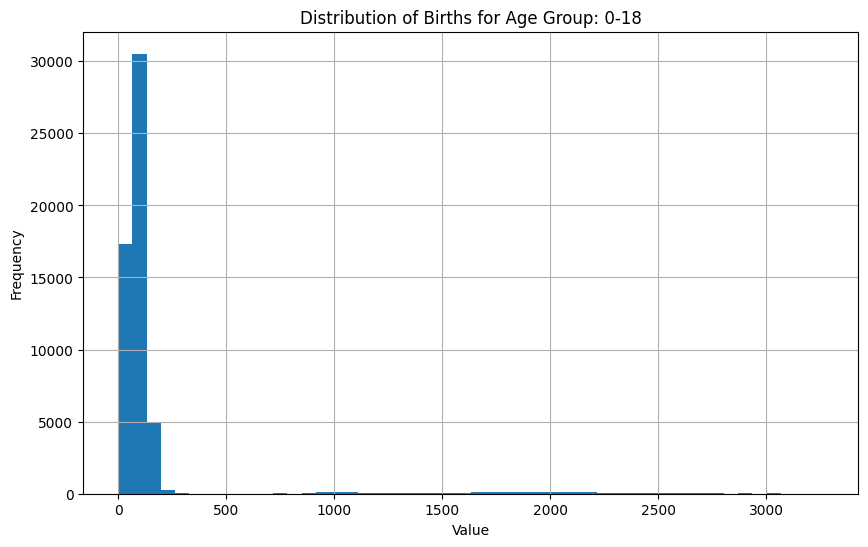

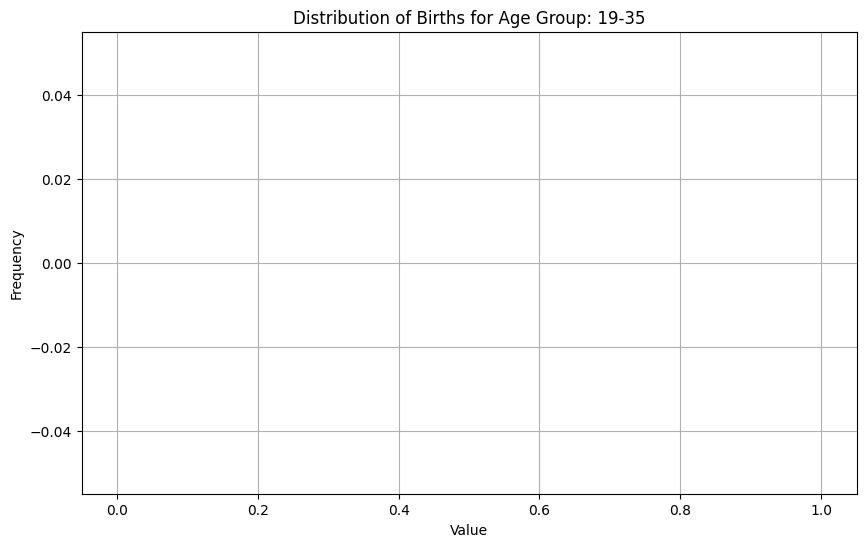

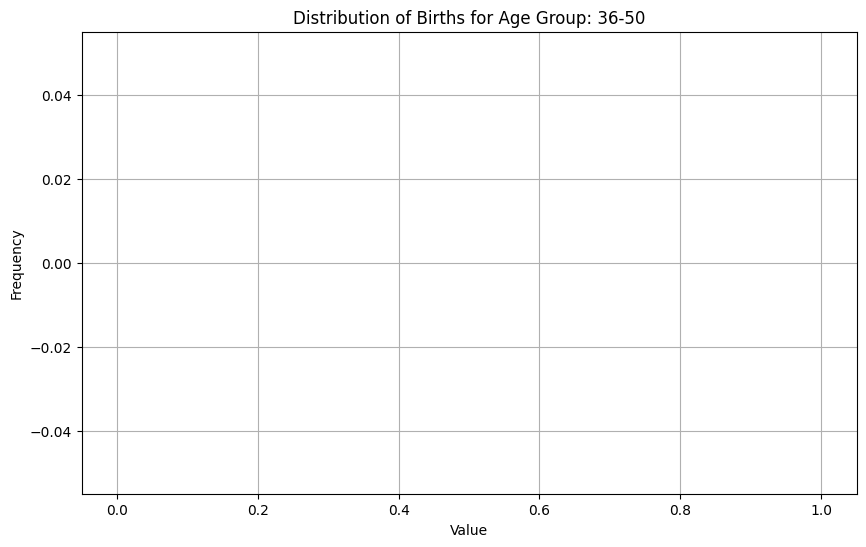

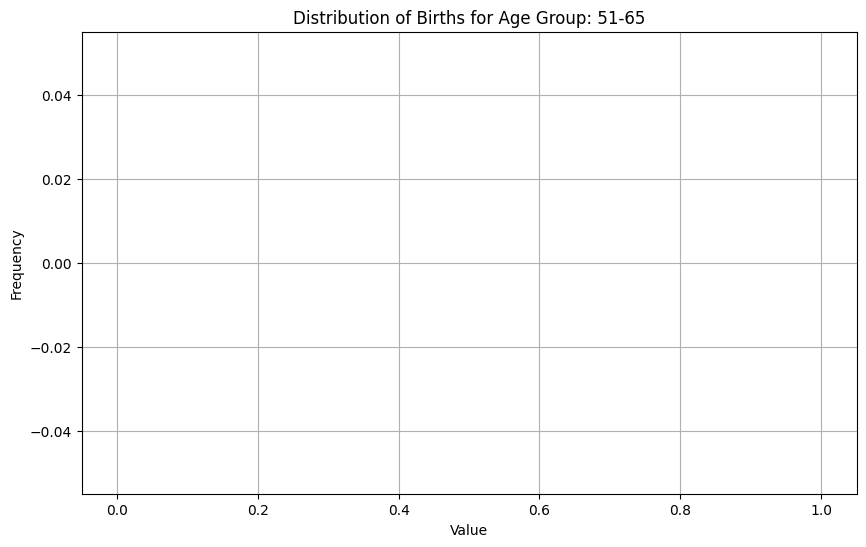

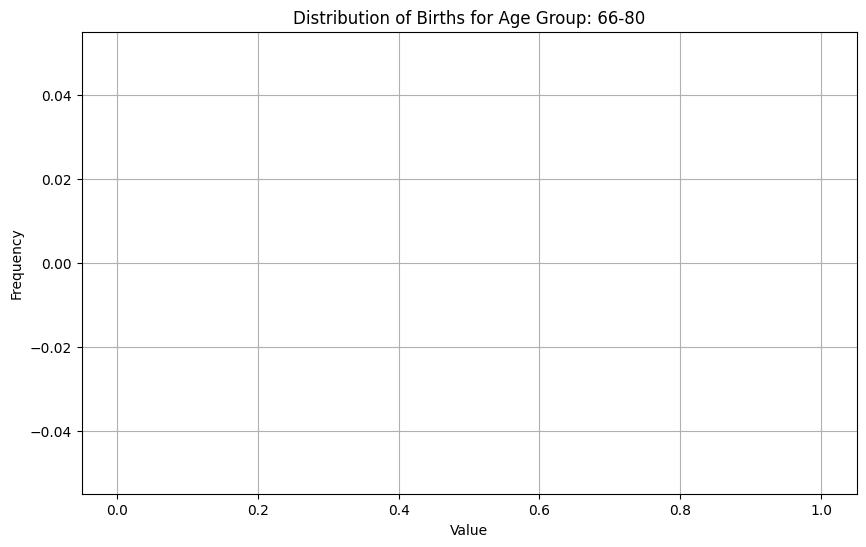

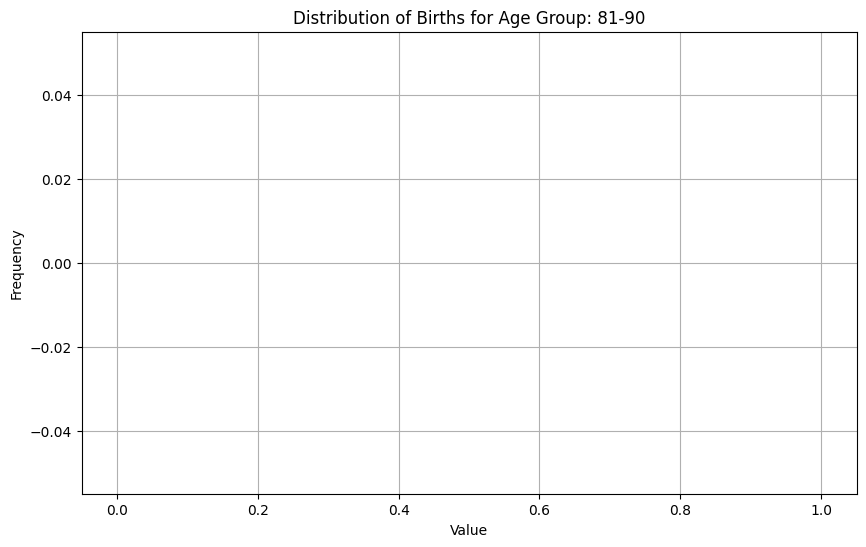

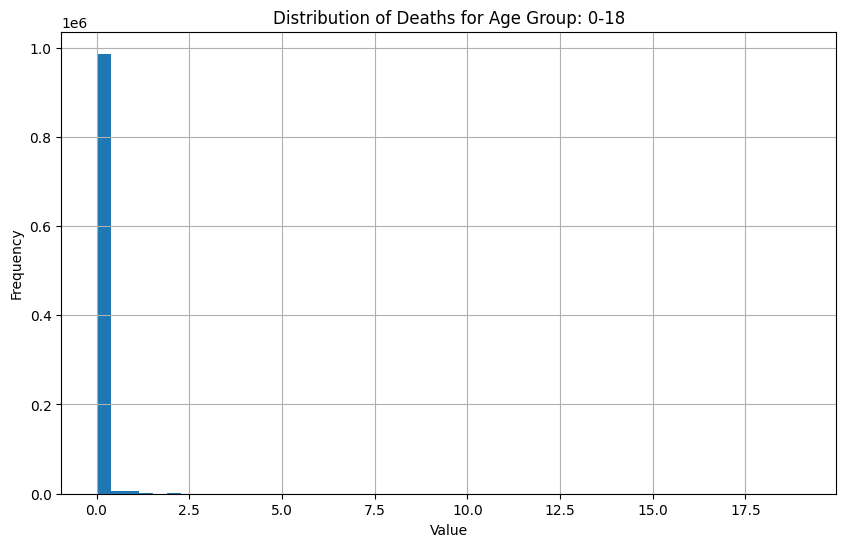

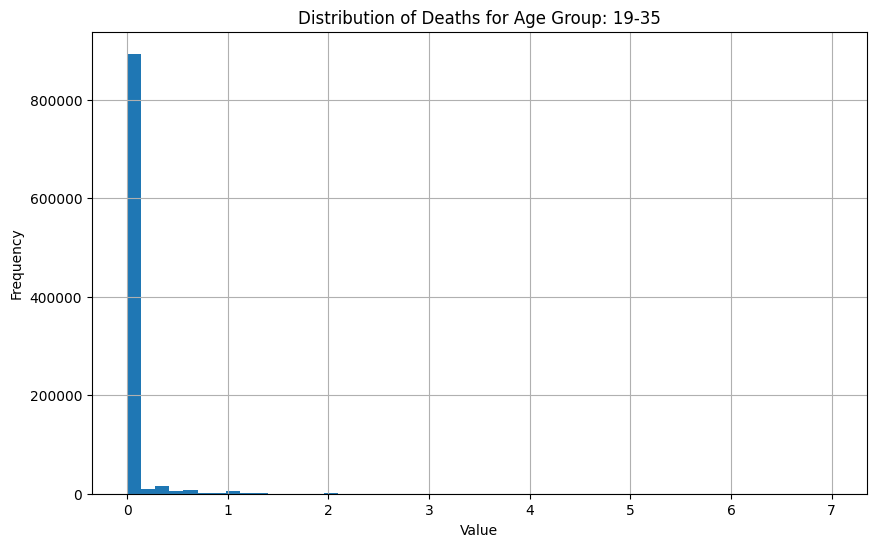

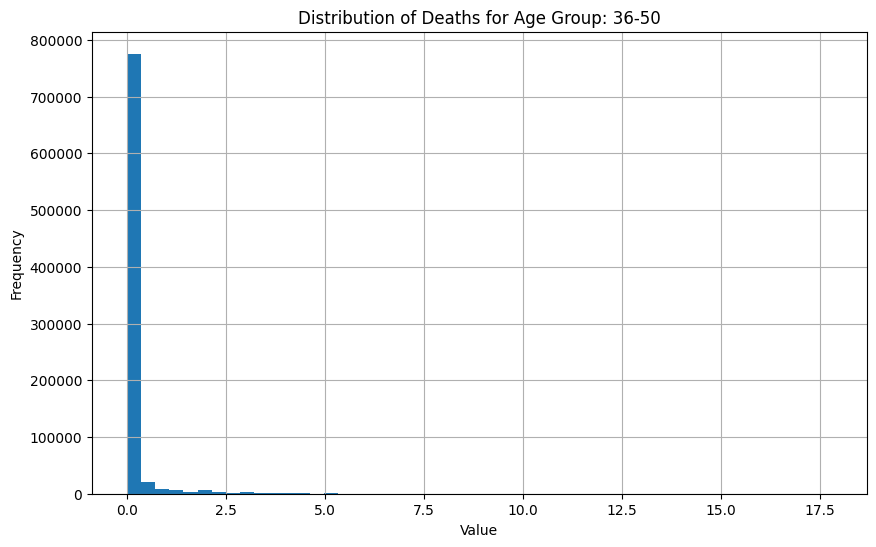

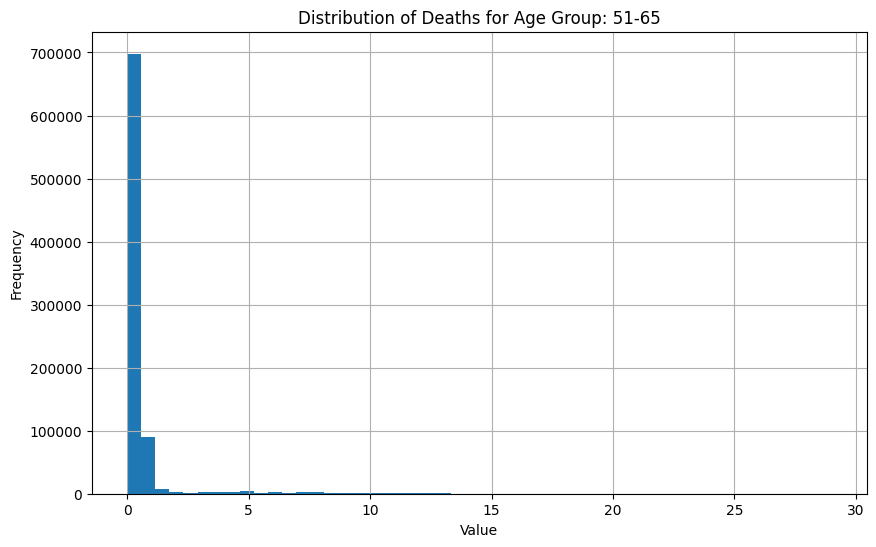

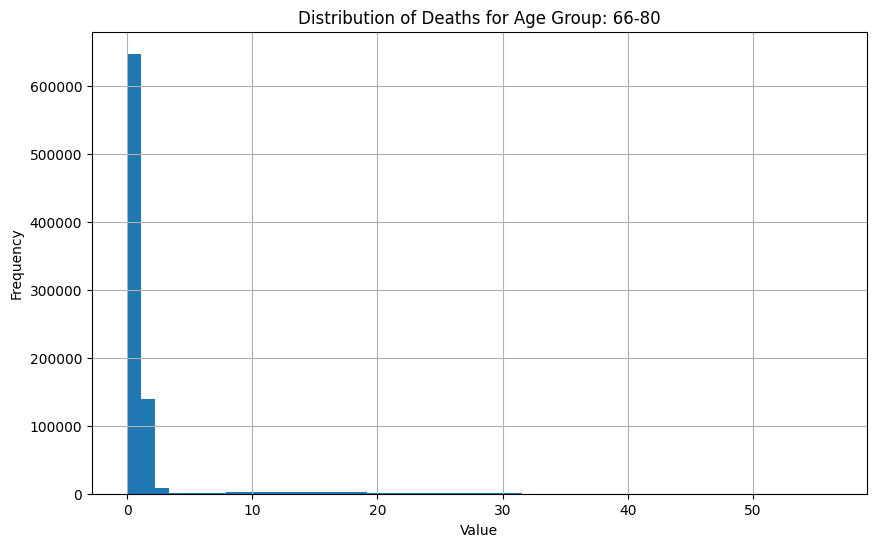

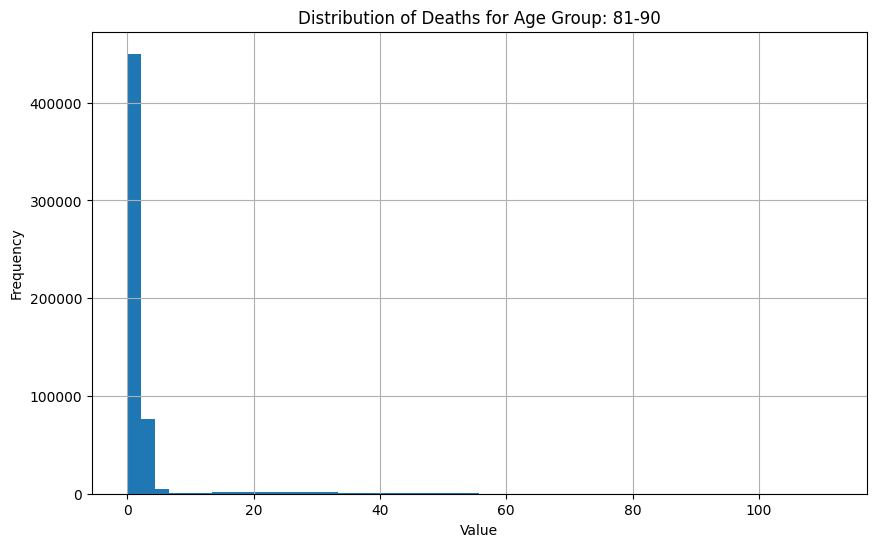

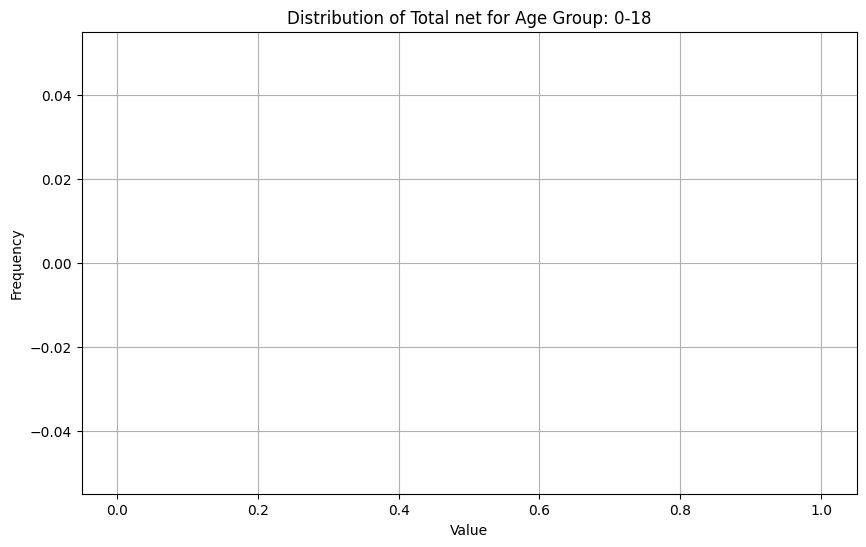

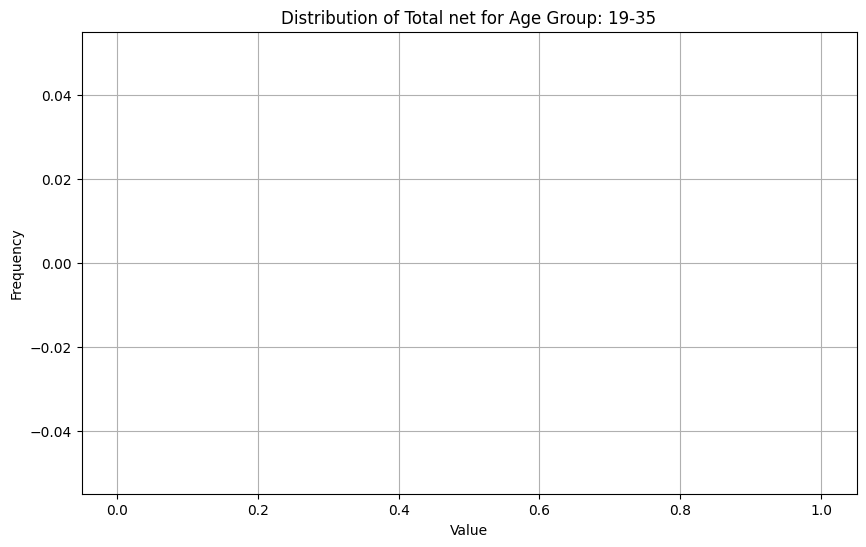

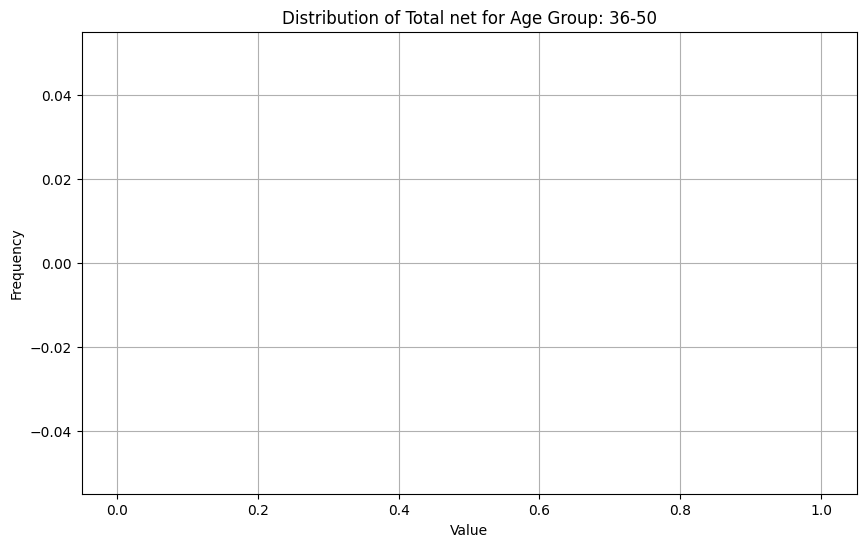

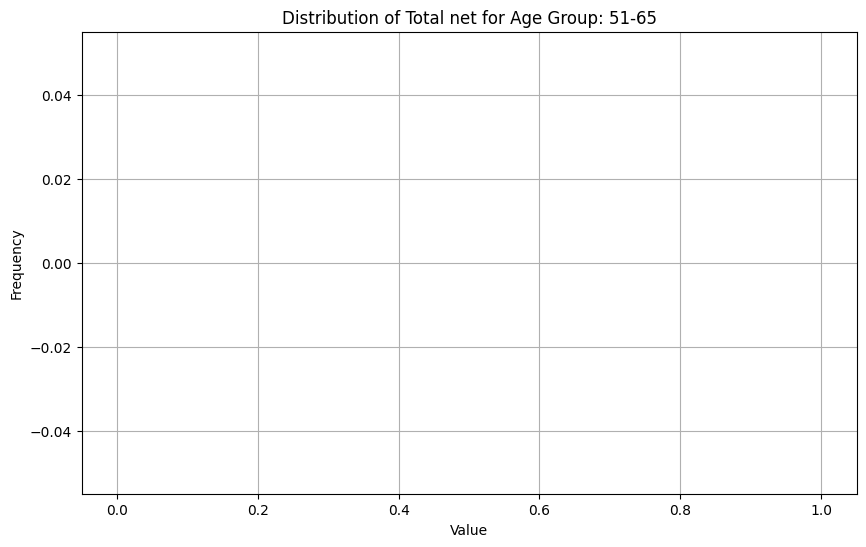

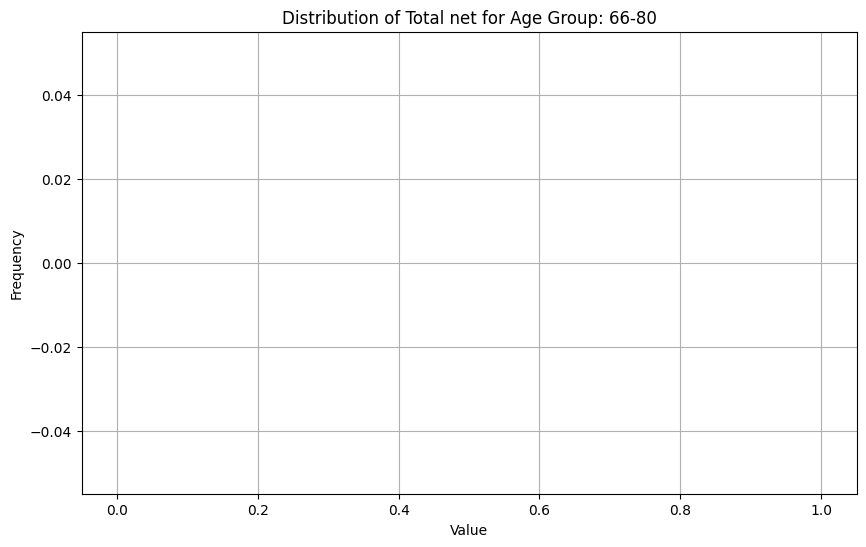

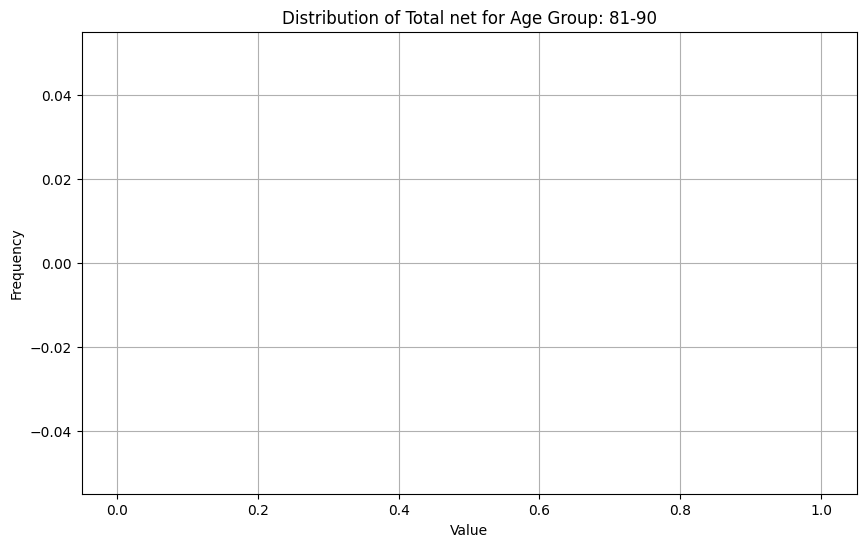

In [ ]:
# Components of interest
components_of_interest = ['births', 'deaths', 'total net']

# Plot distribution for each component by age group
for component in components_of_interest:
    for age_group in labels:
        plt.figure(figsize=(10, 6))
        subset = combined_10yr_fert_age_bins[(combined_10yr_fert_age_bins['component'] == component) & (combined_10yr_fert_age_bins['age_group'] == age_group)]
        subset['value'].hist(bins=50)
        plt.title(f'Distribution of {component.capitalize()} for Age Group: {age_group}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

### population pyramid

In [ ]:
combined_10yr_fert_age_bins_popn = combined_10yr_fert_age_bins[combined_10yr_fert_age_bins['component'] == 'popn']
population_pyramids_unit_age = combined_10yr_fert_age_bins_popn.groupby(['year', 'la_name', 'age_group', 'sex']).agg({'value': 'sum'}).reset_index()

C:\Users\sebastianheslinrees\AppData\Local\Temp\8\ipykernel_19500\787766185.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [124]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='location-dropdown',
        options=[{'label': loc, 'value': loc} for loc in population_pyramids['la_name'].unique()],
        value=population_pyramids['la_name'].unique()[0]
    ),
    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(year), 'value': year} for year in population_pyramids['year'].unique()],
        value=population_pyramids['year'].unique()[0]
    ),
    dcc.Graph(id='population-pyramid')
])

@app.callback(
    Output('population-pyramid', 'figure'),
    [Input('location-dropdown', 'value'),
     Input('year-dropdown', 'value')]
)
def update_pyramid(selected_location, selected_year):
    filtered_data = population_pyramids[(population_pyramids['year'] == selected_year) & 
                                        (population_pyramids['la_name'] == selected_location)]
    pyramid_data = filtered_data.pivot(index='age_group', columns='sex', values='value').fillna(0)

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

    fig.add_trace(go.Bar(x=-pyramid_data.get('male', []), y=pyramid_data.index, 
                         orientation='h', name='Male', marker=dict(color='blue')), row=1, col=1)

    fig.add_trace(go.Bar(x=pyramid_data.get('female', []), y=pyramid_data.index, 
                         orientation='h', name='Female', marker=dict(color='pink')), row=1, col=2)

    fig.update_layout(title_text=f'Population Pyramid for {selected_location} in {selected_year}', 
                      barmode='overlay', xaxis_title='Population',
                      xaxis2_title='Population', yaxis_title='Age Group',
                      showlegend=False, height=600, width=800)

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=3333
)
 
 

In [211]:
population_pyramids_unit_age

,year,la_name,age_group,sex,value
0,2011.0,Barking and Dagenham,0-18,female,52399.7
1,2011.0,Barking and Dagenham,0-18,male,55216.4
2,2011.0,Barking and Dagenham,19-35,female,50462.5
3,2011.0,Barking and Dagenham,19-35,male,46317.5
4,2011.0,Barking and Dagenham,36-50,female,41990.4
...,...,...,...,...,...
15835,2050.0,Westminster,51-65,male,33127.2
15836,2050.0,Westminster,66-80,female,27568.9
15837,2050.0,Westminster,66-80,male,22661.1
15838,2050.0,Westminster,81-90,female,11536.8


In [226]:
combined_10yr_fert_popn = combined_10yr_fert[combined_10yr_fert['component'] == 'popn']
population_pyramids_unit_age = combined_10yr_fert_popn.copy()
population_pyramids_unit_age = population_pyramids_unit_age[~population_pyramids_unit_age['gss_code_ward'].isna()]

In [227]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='location-dropdown',
        options=[{'label': loc, 'value': loc} for loc in population_pyramids['la_name'].unique()],
        value=population_pyramids['la_name'].unique()[0]
    ),
    dcc.Graph(id='population-pyramid')
])

@app.callback(
    Output('population-pyramid', 'figure'),
    [Input('location-dropdown', 'value')]
)
def update_pyramid(selected_location):
    # Filter data for the selected location
    filtered_data = population_pyramids[population_pyramids['la_name'] == selected_location]

        # Negate female population values to create a pyramid
    filtered_data['value'] = filtered_data.apply(lambda row: -row['value'] if row['sex'] == 'female' else row['value'], axis=1)

    # Create a plotly express bar chart with animation
    fig = px.bar(
        filtered_data,
        x='value',
        y='age_group',
        color='sex',
        animation_frame='year',
        orientation='h',
        title=f'Population Pyramid for {selected_location}',
        labels={'value': 'Population', 'age_group': 'Age Group'},
        color_discrete_map={'male': 'blue', 'female': 'pink'},
        range_x=[-filtered_data['value'].max()*1.2, filtered_data['value'].max()*1.2],
        height=600,
    )

    # Update layout for better appearance
    fig.update_layout(
        barmode='relative',
        xaxis_title='Population',
        yaxis_title='Age Group',
        showlegend=True,
        width=800,
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=1223)
 

In [ ]:
#for unit age
combined_10yr_fert_popn = combined_10yr_fert[combined_10yr_fert['component'] == 'popn']
population_pyramids_unit_age = combined_10yr_fert_popn.copy()
population_pyramids_unit_age = population_pyramids_unit_age[~population_pyramids_unit_age['gss_code_ward'].isna()]

In [235]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='location-dropdown',
        options=[{'label': loc, 'value': loc} for loc in population_pyramids_unit_age['la_name'].unique()],
        value=population_pyramids_unit_age['la_name'].unique()[0]
    ),
    dcc.Graph(id='population-pyramid')
])

@app.callback(
    Output('population-pyramid', 'figure'),
    [Input('location-dropdown', 'value')]
)
def update_pyramid(selected_location):
    # Filter data for the selected location
    filtered_data = population_pyramids_unit_age[population_pyramids_unit_age['la_name'] == selected_location]

    # Negate female population values to create a pyramid
    filtered_data['value'] = filtered_data.apply(lambda row: -row['value'] if row['sex'] == 'female' else row['value'], axis=1)

    # Create a plotly express bar chart with animation
    fig = px.bar(
        filtered_data,
        x='value',
        y='age',
        color='sex',
        animation_frame='year',
        orientation='h',
        title=f'Population Pyramid for {selected_location}',
        labels={'value': 'Population', 'age': 'Age'},
        color_discrete_map={'male': 'blue', 'female': 'pink'},
        #range_x=[-filtered_data['value'].max(), filtered_data['value'].max()],
        height=600,
        hover_data={'ward_name': True}  # Add ward_name to hover information
    )

    # Update layout for better appearance
    fig.update_layout(
        barmode='relative',
        xaxis_title='Population',
        yaxis_title='Age',
        showlegend=True,
        width=800,
    )
    return fig
    

if __name__ == '__main__':
    app.run_server(debug=True, port=1223)

In [238]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='location-dropdown',
        options=[{'label': loc, 'value': loc} for loc in population_pyramids_unit_age['la_name'].unique()],
        value=population_pyramids_unit_age['la_name'].unique()[0]
    ),
    dcc.Dropdown(
        id='ward-dropdown'
    ),
    dcc.Graph(id='population-pyramid')
])

@app.callback(
    Output('ward-dropdown', 'options'),
    Output('ward-dropdown', 'value'),
    Input('location-dropdown', 'value')
)
def update_ward_dropdown(selected_location):
    # Filter data for the selected location to get ward names
    filtered_data = population_pyramids_unit_age[population_pyramids_unit_age['la_name'] == selected_location]
    
    # Get unique ward names for the selected location
    ward_options = [{'label': ward, 'value': ward} for ward in filtered_data['ward_name'].unique()]
    
    # Return the options and set the default value to the first ward
    return ward_options, ward_options[0]['value'] if ward_options else None

@app.callback(
    Output('population-pyramid', 'figure'),
    Input('location-dropdown', 'value'),
    Input('ward-dropdown', 'value')
)
def update_pyramid(selected_location, selected_ward):
    # Filter data for the selected location and ward
    filtered_data = population_pyramids_unit_age[
        (population_pyramids_unit_age['la_name'] == selected_location) & 
        (population_pyramids_unit_age['ward_name'] == selected_ward)
    ]

    # Negate female population values to create a pyramid
    filtered_data['value'] = filtered_data.apply(lambda row: -row['value'] if row['sex'] == 'female' else row['value'], axis=1)

    # Create a plotly express bar chart with animation
    fig = px.bar(
        filtered_data,
        x='value',
        y='age',
        color='sex',
        animation_frame='year',
        orientation='h',
        title=f'Population Pyramid for {selected_location} - {selected_ward}',
        labels={'value': 'Population', 'age': 'Age'},
        color_discrete_map={'male': 'blue', 'female': 'pink'},
        height=600,
        hover_data={'ward_name': True}
    )

    # Update layout for better appearance
    fig.update_layout(
        barmode='relative',
        xaxis_title='Population',
        yaxis_title='Age',
        showlegend=True,
        width=800,
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=1223)


#### add selection for indiviual ward and all wards

In [241]:
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='location-dropdown',
        options=[{'label': loc, 'value': loc} for loc in population_pyramids_unit_age['la_name'].unique()] + [{'label': 'London Total (All LAs)', 'value': 'London Total (All LAs)'}],
        value=population_pyramids_unit_age['la_name'].unique()[0]
    ),
    dcc.Dropdown(
        id='ward-dropdown'
    ),
    dcc.Graph(id='population-pyramid')
])

@app.callback(
    Output('ward-dropdown', 'options'),
    Output('ward-dropdown', 'value'),
    Input('location-dropdown', 'value')
)
def update_ward_dropdown(selected_location):
    if selected_location == 'London Total (All LAs)':
        # If "London Total (All LAs)" is selected, disable the ward dropdown
        return [{'label': 'All Wards', 'value': 'All Wards'}], 'All Wards'
    else:
        # Filter data for the selected location to get ward names
        filtered_data = population_pyramids_unit_age[population_pyramids_unit_age['la_name'] == selected_location]
        
        # Get unique ward names for the selected location
        ward_options = [{'label': ward, 'value': ward} for ward in filtered_data['ward_name'].unique()]
        
        # Add 'All Wards' option
        ward_options.insert(0, {'label': 'All Wards', 'value': 'All Wards'})
        
        # Return the options and set the default value to 'All Wards'
        return ward_options, 'All Wards'

@app.callback(
    Output('population-pyramid', 'figure'),
    Input('location-dropdown', 'value'),
    Input('ward-dropdown', 'value')
)
def update_pyramid(selected_location, selected_ward):
    if selected_location == 'London Total (All LAs)':
        # Combine data for all locations
        filtered_data = population_pyramids_unit_age.copy()
        title = 'Population Pyramid for London Total (All LAs)'
    elif selected_ward == 'All Wards':
        # Combine data for all wards in the selected location
        filtered_data = population_pyramids_unit_age[population_pyramids_unit_age['la_name'] == selected_location]
        title = f'Population Pyramid for {selected_location} - All Wards'
    else:
        # Filter data for the selected location and ward
        filtered_data = population_pyramids_unit_age[
            (population_pyramids_unit_age['la_name'] == selected_location) & 
            (population_pyramids_unit_age['ward_name'] == selected_ward)
        ]
        title = f'Population Pyramid for {selected_location} - {selected_ward}'

    # Negate female population values to create a pyramid
    filtered_data['value'] = filtered_data.apply(lambda row: -row['value'] if row['sex'] == 'female' else row['value'], axis=1)

    # Create a plotly express bar chart with animation
    fig = px.bar(
        filtered_data,
        x='value',
        y='age',
        color='sex',
        animation_frame='year',
        orientation='h',
        title=title,
        labels={'value': 'Population', 'age': 'Age'},
        color_discrete_map={'male': 'blue', 'female': 'pink'},
        height=600,
        range_x=[-filtered_data['value'].max()*1.2, filtered_data['value'].max()*1.2], #need to keep x-axis consistent over time for comparison
        hover_data={'ward_name': True}
    )

    # Update layout for better appearance
    fig.update_layout(
        barmode='relative',
        xaxis_title='Population',
        yaxis_title='Age',
        showlegend=True,
        width=800,
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=1223)


### Yearly totals by component visulation

In [127]:
yearly_totals = combined_10yr_fert.groupby(['year','component'])['value'].sum().reset_index()
print("Yearly population totals by gss_code and year:\n", yearly_totals)

Yearly population totals by gss_code and year:
        year component       value
0    2002.0   netflow      7036.6
1    2003.0   netflow    -37021.3
2    2004.0   netflow    -16399.9
3    2005.0   netflow     21802.2
4    2006.0   netflow      9229.4
..      ...       ...         ...
162  2049.0      popn  19763868.6
163  2050.0    births    226639.0
164  2050.0    deaths    137879.9
165  2050.0   netflow    -57727.1
166  2050.0      popn  19794455.5

[167 rows x 3 columns]


In [128]:
import plotly.express as px

# Assuming yearly_totals is already defined
# Print the DataFrame to confirm its structure
print("Yearly population totals by year and component:\n", yearly_totals)

# Create a bar graph using Plotly Express
fig = px.line(
    yearly_totals, 
    x='year', 
    y='value', 
    color='component', 
    markers=True,
    title="Yearly Totals by Component Over the Years",
    labels={'value': 'Total Value', 'year': 'Year'},
    
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Total Value',
    legend_title='Component',
    width=900,
    height=600
)

# Show the figure
fig.show()
 

Yearly population totals by year and component:
        year component       value
0    2002.0   netflow      7036.6
1    2003.0   netflow    -37021.3
2    2004.0   netflow    -16399.9
3    2005.0   netflow     21802.2
4    2006.0   netflow      9229.4
..      ...       ...         ...
162  2049.0      popn  19763868.6
163  2050.0    births    226639.0
164  2050.0    deaths    137879.9
165  2050.0   netflow    -57727.1
166  2050.0      popn  19794455.5

[167 rows x 3 columns]


#### Statistical summaries

In [129]:
# Statistical summary for each component
components = combined_10yr_fert['component'].unique()
for component in components:
    subset = combined_10yr_fert[combined_10yr_fert['component'] == component]
    print(f"Statistical summary for {component}:")
    print(subset['value'].describe())
    print("\n")


Statistical summary for births:
count    55614.000000
mean       162.293288
std        377.997791
min          0.000000
25%         59.900000
50%         81.600000
75%        110.900000
max       3264.000000
Name: value, dtype: float64


Statistical summary for deaths:
count    5.060874e+06
mean     8.857977e-01
std      6.327541e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      6.000000e-01
max      8.252000e+02
Name: value, dtype: float64


Statistical summary for popn:
count    5.190640e+06
mean     1.426107e+02
std      3.632293e+02
min      0.000000e+00
25%      4.500000e+01
50%      7.120000e+01
75%      1.036000e+02
max      5.922600e+03
Name: value, dtype: float64


Statistical summary for netflow:
count    5.120934e+06
mean    -1.821169e-01
std      2.074216e+01
min     -7.130000e+02
25%     -2.300000e+00
50%     -4.000000e-01
75%      1.200000e+00
max      1.938000e+03
Name: value, dtype: float64




#### Below has been taken a merged into the above function so can be deleted from below---------------------------------------------------------------------

#### Z scores

In [187]:
combined_10yr_fertcombined_10yr_fert.drop(columns = ['gss_code_ward','ward_name'])

TypeError: 'method' object is not subscriptable

In [130]:
#zscores value for each components

import pandas as pd
from scipy.stats import zscore

# Initialize a dictionary to store outliers DataFrames for each component
outliers_dict = {}

# Components in your dataset
components = ['births', 'deaths', 'popn', 'netflow']

# Z-score analysis for each component
for component in components:
    # Filter the data for the current component
    subset = combined_10yr_fert[combined_10yr_fert['component'] == component].copy()

    # Calculate Z-scores for the 'value' column
    subset['z_score'] = zscore(subset['value'])

    # Identify outliers (Z-score > 3 or < -3)
    outliers = subset[subset['z_score'].abs() > 4]

    # Store outliers in the dictionary
    outliers_dict[component] = outliers

    # Print the outliers for the current component
    print(f"Outliers for {component} based on Z-score:\n", outliers)
    print("\n")

# Create separate DataFrames for each component's outliers
outliers_births_z_scores = outliers_dict['births']
outliers_deaths_z_scores = outliers_dict['deaths']
outliers_popn_z_scores = outliers_dict['popn']
outliers_netflow_z_scores = outliers_dict['netflow']
 

Outliers for births based on Z-score:
        gss_code               la_name    year     sex  age   value component  \
78    E09000002  Barking and Dagenham  2012.0  female  0.0  1833.0    births   
79    E09000002  Barking and Dagenham  2012.0    male  0.0  1964.0    births   
80    E09000002  Barking and Dagenham  2013.0  female  0.0  1827.0    births   
81    E09000002  Barking and Dagenham  2013.0    male  0.0  2039.0    births   
82    E09000002  Barking and Dagenham  2014.0  female  0.0  1802.0    births   
...         ...                   ...     ...     ...  ...     ...       ...   
2491  E09000032            Wandsworth  2048.0    male  0.0  2195.4    births   
2492  E09000032            Wandsworth  2049.0  female  0.0  2080.0    births   
2493  E09000032            Wandsworth  2049.0    male  0.0  2184.0    births   
2494  E09000032            Wandsworth  2050.0  female  0.0  2066.6    births   
2495  E09000032            Wandsworth  2050.0    male  0.0  2170.0    births   



In [131]:
print(len(outliers_births_z_scores))
print(len(outliers_deaths_z_scores))
print(len(outliers_popn_z_scores))
print(len(outliers_netflow_z_scores))

1552
22298
107490
35703


#### View and compare all outlier dataframes to determine the most frequently occuring outliers

In [144]:
# Filter the global variables to find dataframes with 'outlier' in their name
outlier_dfs = {name: df for name, df in globals().items() if isinstance(df, pd.DataFrame) and 'outlier' in name.lower()}

# Display the name, columns, and length of each dataframe
for name, df in outlier_dfs.items():
    print(f"DataFrame Name: {name}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Length: {len(df)}")
    print("\n" + "-"*50 + "\n")

DataFrame Name: outliers
Columns: ['gss_code', 'la_name', 'year', 'sex', 'age', 'value', 'component', 'gss_code_ward', 'ward_name', 'z_score']
Length: 35703

--------------------------------------------------

DataFrame Name: outliers_births_z_scores
Columns: ['gss_code', 'la_name', 'year', 'sex', 'age', 'value', 'component', 'gss_code_ward', 'ward_name', 'z_score']
Length: 1552

--------------------------------------------------

DataFrame Name: outliers_deaths_z_scores
Columns: ['gss_code', 'la_name', 'year', 'sex', 'age', 'value', 'component', 'gss_code_ward', 'ward_name', 'z_score']
Length: 22298

--------------------------------------------------

DataFrame Name: outliers_popn_z_scores
Columns: ['gss_code', 'la_name', 'year', 'sex', 'age', 'value', 'component', 'gss_code_ward', 'ward_name', 'z_score']
Length: 107490

--------------------------------------------------

DataFrame Name: outliers_netflow_z_scores
Columns: ['gss_code', 'la_name', 'year', 'sex', 'age', 'value', 'compone

In [149]:
# Initialise an empty list to store relevant rows from all DataFrames
all_rows = []

# Loop through all outlier dataframes
for name, df in outlier_dfs.items():
    # Check if 'gss_code' and 'year' columns exist
    if 'gss_code' in df.columns and 'year' in df.columns:
        # Select the relevant columns: 'gss_code', 'year' and 'age' (if it exists)
        cols = ['gss_code', 'year']
        if 'age' in df.columns:
            cols.append('age')

        # Append the relevant data from the current DataFrame to the list
        all_rows.append(df[cols])

# Concatenate all collected data into one DataFrame
if all_rows:
    combined_df = pd.concat(all_rows)

    # Group by 'gss_code', 'year', and 'age' (where applicable) and count occurrences
    tally_df = combined_df.groupby(cols).size().reset_index(name='count')

    # Sort the result by count in descending order
    tally_df = tally_df.sort_values(by='count', ascending=False)

    # Display the top rows of the tally DataFrame
    print(tally_df)
else:
    print("No relevant data found.")
 

        gss_code    year   age  count
7090   E09000003  2050.0  90.0     32
6990   E09000003  2049.0  90.0     31
6890   E09000003  2048.0  90.0     29
6790   E09000003  2047.0  90.0     27
6690   E09000003  2046.0  90.0     27
...          ...     ...   ...    ...
36881  E09000012  2049.0  47.0      1
36882  E09000012  2049.0  48.0      1
36883  E09000012  2049.0  49.0      1
36884  E09000012  2049.0  50.0      1
77486  E09000028  2048.0  65.0      1

[89762 rows x 4 columns]


In [155]:
from collections import defaultdict

# Initialize a dictionary to store the occurrences
occurrences = defaultdict(lambda: {'count': 0, 'dataframes': set()})

# Loop through all outlier dataframes
for name, df in outlier_dfs.items():
    # Check if 'gss_code' and 'year' columns exist
    if 'gss_code' in df.columns and 'year' in df.columns:
        # Select the relevant columns: 'gss_code', 'year' and 'age' (if it exists)
        cols = ['gss_code', 'year']
        if 'age' in df.columns:
            cols.append('age')

        # Iterate through the rows of the current dataframe
        for _, row in df[cols].iterrows():
            key = tuple(row[col] for col in cols)  # Create a tuple key of the combination
            occurrences[key]['count'] += 1  # Increment the count
            occurrences[key]['dataframes'].add(name)  # Add the dataframe name to the set

In [156]:
# Convert the dictionary to a DataFrame for easier viewing
results = []

# Populate the results list with the occurrences
for key, value in occurrences.items():
    row = list(key) + [value['count'], ', '.join(value['dataframes'])]
    results.append(row)

# Create columns names based on the keys and append 'count' and 'dataframes' columns
columns = cols + ['count', 'dataframes']
 

In [159]:
# Convert results list into a DataFrame
tally_df = pd.DataFrame(results, columns=columns)

In [172]:
tally_df['count'].unique()

array([4, 2, 3, 5, 6, 8, 10, 7, 18, 16, 20, 14, 12, 26, 9, 13, 15, 22, 11,
       1, 17, 23, 24, 25, 27, 29, 31, 32, 19, 21, 'inf_outliers',
       'df_temporal_outliers, df_cross_outliers',
       'df_both_outliers, df_temporal_outliers, df_cross_outliers, df_cross_and_temporal_outliers'],
      dtype=object)

In [168]:
tally_df.dtypes

gss_code       object
year          float64
age            object
count          object
dataframes     object
dtype: object

In [173]:
import pandas as pd
from collections import defaultdict

# Initialize a defaultdict to track occurrences of each combination per DataFrame
occurrences = defaultdict(lambda: defaultdict(int))

# Loop through all outlier dataframes
for name, df in outlier_dfs.items():
    # Check if 'gss_code' and 'year' columns exist
    if 'gss_code' in df.columns and 'year' in df.columns:
        # Select the relevant columns: 'gss_code', 'year' and 'age' (if it exists)
        cols = ['gss_code', 'year']
        if 'age' in df.columns:
            cols.append('age')

        # Iterate through the rows of the current dataframe
        for _, row in df[cols].iterrows():
            key = tuple(row[col] for col in cols)  # Create a tuple key of the combination
            occurrences[key][name] += 1  # Increment the count for the specific dataframe

# Convert the defaultdict to a list of dictionaries for easier conversion to a DataFrame
results = []

# Get the list of all dataframe names
all_dataframe_names = list(outlier_dfs.keys())

# Populate the results list with the occurrences
for key, value in occurrences.items():
    # Start with the key (gss_code, year, age)
    row = list(key)

    # Add the counts for each dataframe, setting to 0 if not present
    for df_name in all_dataframe_names:
        row.append(value.get(df_name, 0))

    # Add the total count across all dataframes
    total_count = sum(row[len(key):])  # Sum from the index after the key columns to the end
    row.append(total_count)

    results.append(row)

# Create columns names based on the keys, the dataframe names, and a 'total' column
columns = cols + all_dataframe_names + ['total']

# Convert results list into a DataFrame
tally_df = pd.DataFrame(results, columns=columns)

# Sort the DataFrame by the 'total' column in descending order
tally_df = tally_df.sort_values(by='total', ascending=False)



 

        gss_code    year   age  outliers  outliers_births_z_scores  \
21585  E09000003  2050.0  90.0         0                         0   
21568  E09000003  2049.0  90.0         0                         0   
21551  E09000003  2048.0  90.0         0                         0   
21515  E09000003  2046.0  90.0         0                         0   
21533  E09000003  2047.0  90.0         0                         0   
...          ...     ...   ...       ...                       ...   
89447  E09000007  2022.0     0         0                         0   
89448  E09000030  2013.0     0         0                         0   
89449  E09000030  2014.0     0         0                         0   
89450  E09000030  2022.0     0         0                         0   
89451  E09000033  2022.0     0         0                         0   

       outliers_deaths_z_scores  outliers_popn_z_scores  \
21585                        30                       2   
21568                        29          

In [175]:
tally_df = tally_df.drop(['total'], axis=1)

TypeError: can only concatenate str (not "float") to str

In [ ]:
tally_df['Total'] = tally_df.iloc[:,3:].sum(axis = 1)

In [180]:
tally_df

,gss_code,year,age,outliers,outliers_births_z_scores,outliers_deaths_z_scores,outliers_popn_z_scores,outliers_netflow_z_scores,pivoted_outliers,births_outliers,...,outliers_gender_births,outliers_gender_deaths,outliers_gender_netflow,outliers_gender_popn,df_cross_and_temporal_outliers,gender_births_outliers,gender_deaths_outliers,gender_netflow_outliers,gender_popn_outliers,Total
21585,E09000003,2050.0,90.0,0,0,30,2,0,0,0,...,0,0,0,0,0,0,0,0,0,32
21568,E09000003,2049.0,90.0,0,0,29,2,0,0,0,...,0,0,0,0,0,0,0,0,0,31
21551,E09000003,2048.0,90.0,0,0,27,2,0,0,0,...,0,0,0,0,0,0,0,0,0,29
21515,E09000003,2046.0,90.0,0,0,25,2,0,0,0,...,0,0,0,0,0,0,0,0,0,27
21533,E09000003,2047.0,90.0,0,0,25,2,0,0,0,...,0,0,0,0,0,0,0,0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89447,E09000007,2022.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
89448,E09000030,2013.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
89449,E09000030,2014.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
89450,E09000030,2022.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4


In [181]:
outliers_deaths_z_scores

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name,z_score
9759,E09000002,Barking and Dagenham,2012.0,female,87.0,34.0,deaths,NaN,NaN,5.233345
9760,E09000002,Barking and Dagenham,2012.0,female,88.0,31.0,deaths,NaN,NaN,4.759227
9761,E09000002,Barking and Dagenham,2012.0,female,89.0,36.0,deaths,NaN,NaN,5.549423
9762,E09000002,Barking and Dagenham,2012.0,female,90.0,177.0,deaths,NaN,NaN,27.832962
9845,E09000002,Barking and Dagenham,2012.0,male,82.0,28.0,deaths,NaN,NaN,4.285109
...,...,...,...,...,...,...,...,...,...,...
5228508,E09000032,Wandsworth,2048.0,female,90.0,33.5,deaths,E05014030,West Putney,5.154325
5228690,E09000032,Wandsworth,2049.0,female,90.0,34.3,deaths,E05014030,West Putney,5.280757
5228872,E09000032,Wandsworth,2050.0,female,90.0,35.2,deaths,E05014030,West Putney,5.422992
5350266,E09000033,Westminster,2015.0,female,90.0,26.5,deaths,E05013809,Westbourne,4.048050


In [184]:
outliers_deaths_z_scores[(outliers_deaths_z_scores['gss_code'] == 'E09000003') & (outliers_deaths_z_scores['year'] == 2050) & (outliers_deaths_z_scores['age'] == 90)]

,gss_code,la_name,year,sex,age,value,component,gss_code_ward,ward_name,z_score
23776,E09000003,Barnet,2050.0,female,90.0,825.2,deaths,NaN,NaN,130.274026
23867,E09000003,Barnet,2050.0,male,90.0,557.6,deaths,NaN,NaN,87.982714
679054,E09000003,Barnet,2050.0,female,90.0,37.6,deaths,E05013628,Barnet Vale,5.802286
679145,E09000003,Barnet,2050.0,male,90.0,27.2,deaths,E05013628,Barnet Vale,4.158678
686152,E09000003,Barnet,2050.0,female,90.0,44.1,deaths,E05013629,Brunswick Park,6.829542
686243,E09000003,Barnet,2050.0,male,90.0,30.0,deaths,E05013629,Brunswick Park,4.601188
700348,E09000003,Barnet,2050.0,female,90.0,41.0,deaths,E05013631,Childs Hill,6.339620
721642,E09000003,Barnet,2050.0,female,90.0,28.3,deaths,E05013634,Cricklewood,4.332521
735838,E09000003,Barnet,2050.0,female,90.0,32.8,deaths,E05013636,East Finchley,5.043698
742936,E09000003,Barnet,2050.0,female,90.0,54.4,deaths,E05013637,Edgware,8.457346


## Possible continuation of work

#### Anomaly Detection, IsolationForest

In [132]:
# # Anomaly Detection
# from sklearn.ensemble import IsolationForest

# # Apply Isolation Forest for anomaly detection
# model = IsolationForest(contamination=0.01)
# for component in components:
#     subset = df[df['component'] == component]
#     subset['anomaly'] = model.fit_predict(subset[['value']])
#     anomalies = subset[subset['anomaly'] == -1]
#     print(f"Anomalies detected in {component} using Isolation Forest:\n", anomalies)
#     print("\n")

In [133]:
# import matplotlib.pyplot as plt

# # Time series analysis for each component
# for component in components:
#     plt.figure(figsize=(10, 6))
#     for gss_code in df['gss_code'].unique():
#         subset = df[(df['component'] == component) & (df['gss_code'] == gss_code)]
#         subset.groupby('year')['value'].sum().plot(label=gss_code)
#     plt.title(f'Time Series of {component.capitalize()} by Year')
#     plt.xlabel('Year')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()
